# Simulation for Penalized Potts model
- All levels of interaction
- Field (constant for each point)
- Preference for low number of colors
- Distance between different colors (0 if equal, 1 of different)

- $N$ vertices
- $P(\sigma) = \frac{1}{N^N} \exp((N-n(\sigma))\gamma$), where $n(\sigma) = \text{# of colors used in } \sigma$

- Consider the interaction on the largest hyperedge on lattice $\Lambda$, where $|\Lambda| = N$
- We assign $\eta_{\Lambda} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with $\{1,2,...,N\}$ (a set with $k$ colors corresponds to $k$).
- Each of these corresponds to an energy level in $\{(N-1)\gamma, (N-2)\gamma, ..., 0\}$


- Consider the interaction between adjacent sites (edges) $b$ with size $|b|=2$
- To each edge assign $\eta_{b} \in \mathcal{P}(\{0,1\}^2)$ which is in one-to-one correspondence with the edge being open or closed.
- Each of these corresponds to an energy level in $\{J, -J\}$

- Consider the interaction between adjacent sites and the field, corresponding to $v$ with size $|v|=1$
- To each site assign $\eta_{v} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with the color of the site.
- Each of these corresponds to an energy level in $\{(N-1)\alpha, (N-2)\alpha, ...,(N-k)\alpha, ...,0\}$ where $k$ corresponds to the $k$th preferred color of the field.

- Take $ \upsilon_k =  \frac{e^{((N-k)\gamma)} - e^{((N-k-1)\gamma)}}{e^{((N-1)\gamma)}} $

- Joint distribution
- $Q(\eta, \sigma) = \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} $

- Marginals
- $Q(\eta | \sigma) =  \frac { \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} }{P(\sigma)}$
- $Q(\sigma | \eta) = \frac{1}{|\{\sigma:  \eta(\sigma) \leq \eta(\Lambda)\}|} $

In [7]:
import numpy as np 
from numpy.random import rand
from scipy.special import binom
from unionfind import UnionFind
import matplotlib.pyplot as plt

In [8]:
# Stirling numbers of second kind
S = [[0 for i in range(1001)] for j in range(1001)]

# Combinations
C = [[0 for i in range(1001)] for j in range(1001)]

def stirling(n,k,S):
    if S[n][k] > 0: return S[n][k]
    if k>n or k==0 or n==0: return 0
    if k==1 or k==n:
        S[n][k]=1
    else:
        S[n][k] = stirling(n-1,k-1,S) + k*stirling(n-1,k,S)
    return S[n][k]

def P_exact_cols(n,k,cl,S):
    p = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        p*=i
    p = p*stirling(cl,k,S)
    return p

def combs(n,k,C,S):
    if C[n][k] > 0: return C[n][k]
    if k>n or k==0 or n==0: return 0
    c = 1 # n! / (n-k)!
    for i in range(n-k+1, n+1):
        c*=i
    C[n][k] = c*stirling(n,k,S)
    return C[n][k]

def H(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors
def H_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += k * C[n][k] * (z**k)
    return h

# Denominator in Expected no. of colors squared
def H_t_t(n,z,C):
    h = 0
    for k in range(1,n+1):
        h += (k**2) * C[n][k] * (z**k)
    return h

def E_cols(n,z,C):
    return H_t(n,z,C)/H(n,z,C)

def Var_cols(n,z,C):
    EX_2 = H_t_t(n,z,C)/H(n,z,C)
    v = EX_2 - (E_cols(n,z,C)**2)
    # if v < 0: print("Negative variance in",n,z,C)
    return v

def std_cols(n,z,C):
    return Var_cols(n,z,C)**(0.5)

In [9]:
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr

session = WolframLanguageSession()

for i in range(1001):
    if i%100==0: print(i)
    for j in range(1001):
        stirling(i,j,S)
        combs(i,j,C,S)
        
bell_dict = {}

0
100
200
300
400
500
600
700
800
900
1000


## Main Implementation

In [10]:
# Initial code from https://rajeshrinet.github.io/blog/2014/ising-model/
# Implement Union Find to find clusters in the configurations
# https://github.com/deehzee/unionfind/blob/master/unionfind.py

# Toggle printing for debugging
prt = True

def initial_config(N, no_colors=2, init_type="Noise"):   
    ''' Generate a random color/spin configuration for initialization'''
    if init_type=="Noise":
        return np.random.randint(low=1, high=no_colors+1, size=(N,N))
    elif init_type=="Uniform":
        color = np.random.randint(low=1, high=no_colors+1)
        return np.full((N, N), color)
    return state


def mc_move(config, eta_prob, eta, N, no_colors, sites, param_name, curr_params):
    '''Monte Carlo move using generalized SW algorithm '''
    # Assign eta to each hyperedge
    eta = assign_etas(config, eta_prob, eta, no_colors)
    # Assign labels to each site
    config = assign_labels(config, eta, N, no_colors, sites, param_name, curr_params)
    if prt: print('config:')
    if prt: print(config)
    return config


def number_of_colors (config):
    '''Number of colors used in the given confuration of labels'''
    return len(np.unique(config))


def avg_sites_per_color (config):
    '''Average number of sites each present color has in the configuration'''
    unq = np.unique(config)
    return config.shape[0]*config.shape[1]/len(unq)


def prob_eta_lambda(gamma, no_colors, k):
    '''Probability of the eta lambda corresponding to a certain number of colors'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*gamma) - np.exp((no_colors-k-1)*gamma) ) / np.exp((no_colors-1)*gamma)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*gamma)
    
    
def prob_eta_edge(J, col1, col2):
    '''Probability of the eta edge corresponding to open or not'''
    if col1==col2:
        return 1 - np.exp(-2*J)
    else:
        return np.exp(-2*J)
    
    
def prob_eta_site(alpha, no_colors, k):
    '''Probability of the eta site corresponding to a maximum color number (lower have higher energy)'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*alpha) - np.exp((no_colors-k-1)*alpha) ) / np.exp((no_colors-1)*alpha)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*alpha)

    
def assign_etas(config, eta_prob, eta, no_colors):
    
    '''Assign a number of colors that is at least the current number of colors'''
    eta_lambda = eta[0]
    prob_lambda = eta_prob[0]
    if prt: print('probabilities for no. of colors (lambda):', prob_lambda)
    
    current_k = number_of_colors(config)
    if prt: print('current no. cols (lambda):', current_k)
    p = prob_lambda[current_k-1:]
    p = p / p.sum()
    eta_lambda = np.random.choice((np.arange(current_k, no_colors+1)), p=p)
    eta[0] = eta_lambda
    if prt: print('assigned no. cols (eta_lambda):', eta_lambda)

    '''Assign a closed or open bond to each edge'''
    eta_edges = eta[1]
    prob_edge = eta_prob[1]
    if prt: print('probabilities for edges:', prob_edge)
    
    # loop over edges
    for i in range(eta_edges.shape[0]):
        for j in range(eta_edges.shape[1]):
            for e in range(eta_edges.shape[2]):
                if eta_edges[i,j,e] == -1: continue
                if e==0: current_b = (0 if config[i,j]==config[i+1,j] else 1)          
                elif e==1: current_b = (0 if config[i,j]==config[i,j+1] else 1)      
                p = prob_edge[current_b:]
                p = p / p.sum()
                eta_edge = np.random.choice((np.arange(current_b, 1+1)), p=p) # 0 for present bonds, 1 for not
                eta_edges[i,j,e] = eta_edge
    eta[1] = eta_edges
    if prt: print('assigned bonds (eta_edges):')
    if prt: print(eta_edges[:,:,0])
    if prt: print()
    if prt: print(eta_edges[:,:,1])
    
    '''Assign a color that has at most the current energy for the color (color number is at least the current one)'''
    eta_sites = eta[2]
    prob_site = eta_prob[2]
    if prt: print('probabilities for colors (sites):', prob_site)
    
    # loop over sites
    for i in range(eta_sites.shape[0]):
        for j in range(eta_sites.shape[1]):
            current_s = config[i,j]
            p = prob_site[current_s-1:]
            p = p / p.sum()
            eta_site = np.random.choice((np.arange(current_s, no_colors+1)), p=p)
            eta_sites[i,j] = eta_site
    eta[2] = eta_sites
    if prt: print('assigned max colors (eta_sites):')
    if prt: print(eta_sites)
    
    return eta


def site2str(tup):
    return str(tup[0]) + ',' + str(tup[1])

def str2site(strr):
    t = strr.split(',')
    return [int(x) for x in t]


def brute_force_sample (cluster_constraints, cls, uf, config):
    '''Randomly sample a color for each cluster'''
    max_col = None
    for cluster in uf.components():
        for site_str in cluster:
            site = str2site(site_str)
            max_col = cluster_constraints[cls[site[0],site[1]]]
            cluster_color = np.random.choice((np.arange(1, max_col+1)))
            break
        for site_str in cluster:
            site = str2site(site_str)
            config[site[0],site[1]] = cluster_color
    # if prt: print("done sampling cluster colors")
    
    return config


def sample_config(config, eta, N, no_colors, sites, param_name, curr_params, uf=None, cluster_constraints=None, cls=None):
    
    if uf==None and not only_averages:
        '''Generate clusters from the assigned bonds (eta_edge)'''
        uf = UnionFind(sites)
        eta_edges = eta[1]
        for i in range(eta_edges.shape[0]):
            for j in range(eta_edges.shape[1]):
                for e in range(eta_edges.shape[2]):
                    if eta_edges[i,j,e] == -1: continue
                    if eta_edges[i,j,e] == 0:
                        if e==0: uf.union(site2str((i,j)), site2str((i+1,j)))
                        elif e==1: uf.union(site2str((i,j)), site2str((i,j+1)))    

        '''For each cluster, find the site with strongest constraint (smallest eta_site)
           and assign that eta_site to the entire cluster
        '''
        eta_sites = eta[2]
        cluster_constraints = {}
        cl_n = 0
        cls = np.zeros((eta_sites.shape[0],eta_sites.shape[1]), dtype=np.uint16) # up to 255x255 box
        for cluster in uf.components():
            cl_n += 1
            min_constraint = no_colors
            cluster_root = '-1,-1'
            for site_str in cluster:
                site = str2site(site_str)
                if eta_sites[site[0],site[1]] <= min_constraint:
                    min_constraint = eta_sites[site[0],site[1]]
                    cluster_root = site_str
                cls[site[0],site[1]] = cl_n
            cluster_constraints[cluster_root] = min_constraint
            cluster_constraints[cl_n] = min_constraint
        if prt: print('clusters formed by bonds (eta_edge):')
        if prt: print(cls)
    
    # Case with no field and gamma > 0
    if (curr_params['alpha']==0 and curr_params['gamma']>0):
        if prt: print('Case with no field and gamma > 0')
            
        '''Choose exactly how many colors to use in the configuration'''
        max_colors = eta[0] # eta_lambda
        prob_k = []
        if only_averages:
            no_cl = N*N
        else:
            no_cl = len(uf.components())
        for k in range(1,max_colors+1):
            prob_k.append(P_exact_cols(no_colors,k,no_cl,S))
        if prt: print('prob_k:', prob_k)
        prob_k = [pk / sum(prob_k) for pk in prob_k]
        prob_k = np.array(prob_k)
        if prt: print('prob_k:', prob_k)
        exact_k = np.random.choice((np.arange(1, max_colors+1)), p=prob_k)
        if prt: print('exact number of colors to use in configuration:')
        if prt: print(exact_k)
            
        if only_averages:
            '''Only compute average in case with zero field and no interaction, but with gamma > 0,
               use an arbitray partition (avoid computing Bell polynomials)
            '''
            chosen_colors = range(1,exact_k+1)
            if exact_k == no_colors:
                chosen_partition = [exact_k]
            else:
                chosen_partition = [exact_k-1] + [0]*max(0,no_colors-exact_k-1) + [1]
            part = []
            for i in range(len(chosen_partition)):
                part += ([i+1]*chosen_partition[i])
            chosen_partition = part
            if prt: print('chosen partition:')
            if prt: print(chosen_partition)
            color_arr = []
            for i in range(len(chosen_partition)):
                color_arr += [chosen_colors[i]]*chosen_partition[i]
            config = np.array(color_arr).reshape((N,N))
            return config, None, None

        '''Sample a partition of the no. of clusters into k blocks using Bell polynomials'''
        partition_dict = {}
        if ((no_cl,exact_k) in bell_dict):
            partition_dict = bell_dict[(no_cl,exact_k)]
            if prt: print ("Bell found", (no_cl,exact_k))
        else:
            session.evaluate("subs = Array[x,"+str(no_cl-exact_k+1)+"]")
            partition_dict = session.evaluate("Association@CoefficientRules[BellY["+str(no_cl)+", "+str(exact_k)+", subs], subs]")
            bell_dict[(no_cl,exact_k)] = partition_dict
            if prt: print ("Bell computed", (no_cl,exact_k))
        if prt: print("partition_dict", partition_dict)
        partitions = []
        partition_p = []
        for partition in partition_dict:
            partitions.append(partition)
            partition_p.append(partition_dict[partition])
        if prt: print('partition_p:', partition_p)
        partition_p = [pk / sum(partition_p) for pk in partition_p]
        parition_p = np.array(partition_p)
        if prt: print('partition_p:', partition_p)
        chosen_partition = partitions[np.random.choice((np.arange(0, len(partitions))), p=partition_p)]
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)
        # Transform to actual partition
        part = []
        for i in range(len(chosen_partition)):
            part += ([i+1]*chosen_partition[i])
        chosen_partition = part
        if prt: print('chosen partition:')
        if prt: print(chosen_partition)

        '''Color each block in the partition randomly without replacement'''
        # Choose the colors to be used
        chosen_colors = np.random.choice((np.arange(1, no_colors+1)), len(chosen_partition), replace=False)
        # Choose a random permutation of the given word
        color_arr = []
        for i in range(len(chosen_partition)):
            color_arr += [chosen_colors[i]]*chosen_partition[i]
        color_arr = np.array(color_arr)
        color_arr = np.random.permutation(color_arr)
        if prt: print('colors for clusters:')
        if prt: print(color_arr)
        
        '''Color each cluster with the assigned color'''
        i=0
        for cluster in uf.components():
            cluster_color = color_arr[i]
            for site_str in cluster:
                site = str2site(site_str)
                config[site[0],site[1]] = cluster_color
            i+=1
    
    # Case with field and gamma > 0 or case with gamma = 0
    else:
        '''Randomly sample a color for each cluster'''
        # if prt: print('Case with field and gamma > 0 or case with gamma = 0')
        config = brute_force_sample (cluster_constraints, cls, uf, config)
            
    return config, uf, cluster_constraints, cls


def assign_labels(config, eta, N, no_colors, sites, param_name, curr_params):
    '''Assign a color configuration chosen uniformly from the configurations compatible with eta'''
    # Brute force until compatible with eta_lambda
    max_colors = eta[0] # eta_lambda
    config, uf, cluster_constraints, cls = sample_config(config, eta, N, no_colors, sites, param_name, curr_params)
    retry_cnt = 0
    while number_of_colors(config) > max_colors:
        config, uf, cluster_constraints, cls = sample_config(config, eta, N, no_colors, sites, param_name, curr_params, uf, cluster_constraints, cls)
        retry_cnt += 1
    if prt: print('retried sample (too many colors)', retry_cnt, "times")
    return config

## Experiment routine

In [18]:
def single_experiment (N, no_cols, gamma=0, J=0, alpha=0, iters=100, init_type="Noise"):
    curr_params = {}
    curr_params['gamma'], curr_params['J'], curr_params['alpha'] = gamma, J, alpha
    param_name = "Alpha"

    '''Probabilities ordered from highest (high energy) to lowest'''
    lambda_prob = np.zeros(no_cols)
    for j in range(no_cols):
        lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
    print('lambda probabilities:', lambda_prob)

    edge_prob = np.zeros(2)
    edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
    edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
    print('edge probabilities:', edge_prob)

    site_prob = np.zeros(no_cols)
    for j in range(no_cols):
        site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
    print('site probabilities:', site_prob)

    eta_prob = (lambda_prob, edge_prob, site_prob)

    '''Current states of eta'''
    eta_lambda = 0
    eta_edges = np.zeros((N,N,2), dtype=np.int8)
    # Special edge cases (no neighbors at the border)
    eta_edges[:,N-1,1] = -1
    eta_edges[N-1,:,0] = -1
    eta_sites = np.zeros((N,N), dtype=np.int8)
    eta = [eta_lambda, eta_edges, eta_sites]

    '''List of sites (tuples) for Union-Find'''
    sites = []
    for i in range(N):
        for j in range(N):
            sites.append(str(i)+','+str(j))

    config = initial_config(N, no_cols, init_type=init_type)
    print('\ninitial config:')
    print(config)
    for i in range(iters):
        if i%100 == 0:
            print('\n' + '-'*50 + ' iter ' + str(i) + ' ' + '-'*50)
            plt.imshow(config)
            plt.show()
            print(number_of_colors (config))
        config = mc_move(config, eta_prob, eta, N, no_cols, sites, param_name, curr_params)

    print('\nfinal config:')
    print(config)
    print(number_of_colors (config))
    plt.imshow(config)
    plt.show()

    session.terminate()

In [265]:
'''Probabilities ordered from highest (high energy) to lowest'''
no_cols=16
gamma=1
expt, expt2=0,0
x=np.exp(gamma)
lambda_prob = np.zeros(no_cols)
for j in range(no_cols):
    lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
    expt += lambda_prob[j]*(j+1)
    expt2 += 1 / (x**j)
print('lambda probabilities:', lambda_prob)
print('Expected', expt, expt2, np.exp(gamma)/(np.exp(gamma)-1))

lambda probabilities: [6.32120559e-01 2.32544158e-01 8.55482149e-02 3.14714295e-02
 1.15776919e-02 4.25919482e-03 1.56687021e-03 5.76419338e-04
 2.12052824e-04 7.80098743e-05 2.86982290e-05 1.05574884e-05
 3.88388295e-06 1.42880069e-06 5.25626399e-07 3.05902321e-07]
Expected 1.5819765288413017 1.5819765288413015 1.5819767068693265


lambda probabilities: [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.52299797e-08]
edge probabilities: [0.75340304 0.24659696]
site probabilities: [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.91393119]

initial config:
[[ 8 10  1 ...  8  8  5]
 [10 10  4 ...  5  6  7]
 [ 2 10  4 ...  7  4  5]
 ...
 [ 9  6  7 ...  7  4  1]
 [10  9 10 ... 10  2  3]
 [10  5  2 ...  8  8 10]]

-------------------- iter 0 --------------------


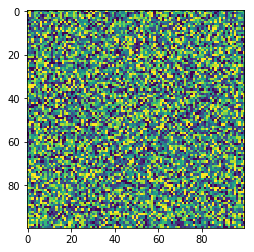

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.52299797e-08]
current no. cols (lambda): 10
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.75340304 0.24659696]
assigned bonds (eta_edges):
[[ 1  0  1 ...  1  1  1]
 [ 1  0  1 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 ...
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 1  1  1 ...  0  1 -1]
 [ 0  1  1 ...  1  1 -1]
 [ 1  1  1 ...  1  1 -1]
 ...
 [ 1  1  0 ...  1  1 -1]
 [ 1  1  1 ...  1  1 -1]
 [ 1  1  1 ...  0  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.91393119]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters form

assigned bonds (eta_edges):
[[ 1  1  1 ...  0  1  1]
 [ 1  0  1 ...  1  1  0]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 1  0  0 ...  1  1  0]
 [ 1  0  0 ...  1  0  0]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 1  1  1 ...  1  1 -1]
 [ 0  0  1 ...  1  1 -1]
 [ 0  1  1 ...  1  1 -1]
 ...
 [ 0  0  1 ...  0  1 -1]
 [ 0  0  0 ...  1  1 -1]
 [ 1  0  1 ...  1  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.91393119]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [ 9 10 10 ... 10 10 10]
 [10 10  5 ... 10 10 10]
 [10 10  5 ... 10 10 10]]
clusters formed by bonds (eta_edge):
[[   1    2    3 ...   76   77   78]
 [  79   79   79 ...   76  142  143]
 [  79   79  144 ...  141  190  143]
 ...
 [5622 5622 5622 ... 5621 5621 5680]
 [5622 5622 5622 ... 5729 5730 5680]
 [5731 5622 5622 ... 5728 5730 5680]]
Case with field and gamma > 0 or case with gamma = 0
done 

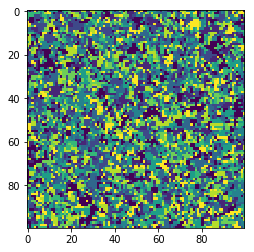

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.52299797e-08]
current no. cols (lambda): 10
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.75340304 0.24659696]
assigned bonds (eta_edges):
[[ 1  1  1 ...  1  0  1]
 [ 1  0  1 ...  1  1  1]
 [ 0  1  1 ...  1  0  1]
 ...
 [ 1  1  1 ...  1  0  0]
 [ 1  0  1 ...  1  1  1]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 1  1  1 ...  1  1 -1]
 [ 1  0  0 ...  0  0 -1]
 [ 0  1  1 ...  1  1 -1]
 ...
 [ 0  1  1 ...  1  0 -1]
 [ 1  1  0 ...  1  0 -1]
 [ 1  1  1 ...  1  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.91393119]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters form

assigned bonds (eta_edges):
[[ 1  1  0 ...  0  1  1]
 [ 1  0  0 ...  1  1  1]
 [ 1  1  1 ...  1  0  1]
 ...
 [ 0  1  0 ...  1  1  0]
 [ 1  1  1 ...  1  0  0]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 1  1  1 ...  1  0 -1]
 [ 1  1  0 ...  1  1 -1]
 [ 1  1  0 ...  1  1 -1]
 ...
 [ 0  0  1 ...  1  0 -1]
 [ 1  1  1 ...  1  1 -1]
 [ 1  1  0 ...  1  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.91393119]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters formed by bonds (eta_edge):
[[   1    2    3 ...  195   98   98]
 [ 100  101    3 ...  195  198  199]
 [ 200  101    3 ...  294  477  296]
 ...
 [1316 1316 1316 ... 1488 1489 1489]
 [1316 1490 1316 ... 1578 1579 1489]
 [1580 1581 1582 ... 1665 1579 1489]]
Case with field and gamma > 0 or case with gamma = 0
done 

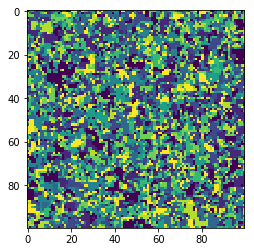

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.52299797e-08]
current no. cols (lambda): 10
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.75340304 0.24659696]
assigned bonds (eta_edges):
[[ 1  0  1 ...  1  1  0]
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  0  0]
 ...
 [ 1  0  1 ...  1  1  0]
 [ 1  1  1 ...  1  1  1]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 1  1  1 ...  1  1 -1]
 [ 1  1  1 ...  1  1 -1]
 [ 0  1  1 ...  1  0 -1]
 ...
 [ 0  1  1 ...  1  1 -1]
 [ 1  0  1 ...  1  1 -1]
 [ 1  1  0 ...  1  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.91393119]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters form

assigned bonds (eta_edges):
[[ 1  0  0 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  0  0]
 ...
 [ 0  1  0 ...  1  1  0]
 [ 1  1  0 ...  1  1  0]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 1  0  0 ...  1  0 -1]
 [ 1  0  1 ...  0  0 -1]
 [ 1  1  1 ...  0  0 -1]
 ...
 [ 1  1  0 ...  0  0 -1]
 [ 1  1  0 ...  1  1 -1]
 [ 0  1  0 ...  1  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.91393119]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10  8 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters formed by bonds (eta_edge):
[[   1    2    2 ...   92   93   93]
 [  95    2    2 ...  178  178  178]
 [ 181  182  183 ...  255  255  255]
 ...
 [1346 1347 1257 ... 1423 1423 1423]
 [1346 1425 1257 ... 1517 1518 1423]
 [1519 1519 1257 ... 1611 1612 1423]]
Case with field and gamma > 0 or case with gamma = 0
done 

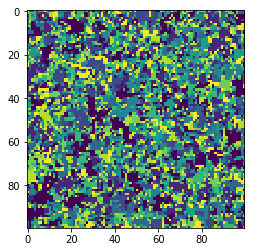

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.52299797e-08]
current no. cols (lambda): 10
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.75340304 0.24659696]
assigned bonds (eta_edges):
[[ 0  1  1 ...  0  0  0]
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  0  0  0]
 ...
 [ 0  0  1 ...  1  1  0]
 [ 1  0  1 ...  0  1  1]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 1  0  1 ...  0  0 -1]
 [ 1  0  0 ...  0  1 -1]
 [ 1  1  1 ...  1  0 -1]
 ...
 [ 1  1  0 ...  1  1 -1]
 [ 1  1  1 ...  1  1 -1]
 [ 1  1  1 ...  0  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.91393119]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10  9 ...  8 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters form

assigned bonds (eta_edges):
[[ 1  1  1 ...  0  0  0]
 [ 1  0  1 ...  1  1  1]
 [ 1  1  1 ...  0  1  1]
 ...
 [ 1  0  0 ...  0  1  1]
 [ 0  0  0 ...  1  1  1]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 1  0  1 ...  0  1 -1]
 [ 1  0  1 ...  0  0 -1]
 [ 1  1  1 ...  0  1 -1]
 ...
 [ 1  0  0 ...  1  1 -1]
 [ 1  0  0 ...  0  0 -1]
 [ 1  0  1 ...  0  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.91393119]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters formed by bonds (eta_edge):
[[   1    2    2 ...   94   94   94]
 [  97   98   98 ...   94   94   94]
 [ 182   98  184 ...  272  272  274]
 ...
 [1286 1208 1208 ... 1361 1362 1363]
 [1364 1208 1208 ... 1361 1361 1361]
 [1364 1208 1208 ... 1528 1528 1529]]
Case with field and gamma > 0 or case with gamma = 0
done 

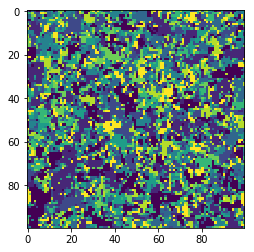

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.52299797e-08]
current no. cols (lambda): 10
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.75340304 0.24659696]
assigned bonds (eta_edges):
[[ 1  1  1 ...  0  0  1]
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  0  1  0]
 ...
 [ 1  0  0 ...  1  1  1]
 [ 1  1  0 ...  1  1  1]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 1  1  1 ...  1  1 -1]
 [ 0  1  1 ...  1  0 -1]
 [ 0  1  1 ...  1  1 -1]
 ...
 [ 1  0  0 ...  1  1 -1]
 [ 1  0  0 ...  1  0 -1]
 [ 1  1  1 ...  1  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.91393119]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [ 9 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters form

assigned bonds (eta_edges):
[[ 1  0  1 ...  1  0  1]
 [ 1  1  1 ...  1  1  0]
 [ 1  1  0 ...  0  1  1]
 ...
 [ 1  0  0 ...  1  1  0]
 [ 1  1  1 ...  0  0  0]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 1  1  1 ...  1  1 -1]
 [ 1  1  1 ...  1  0 -1]
 [ 1  1  1 ...  1  1 -1]
 ...
 [ 0  0  0 ...  1  0 -1]
 [ 1  0  0 ...  1  0 -1]
 [ 1  1  0 ...  1  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.91393119]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10  8]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [ 7 10 10 ... 10 10 10]
 [ 9 10  6 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters formed by bonds (eta_edge):
[[   1    2    3 ...   91   93   94]
 [  95    2   97 ...  175   93   93]
 [ 178  179  180 ...  261  262   93]
 ...
 [ 580  580  580 ... 1144 1296 1296]
 [1297  580  580 ... 1377 1296 1296]
 [1379 1381  580 ... 1377 1296 1296]]
Case with field and gamma > 0 or case with gamma = 0
done 

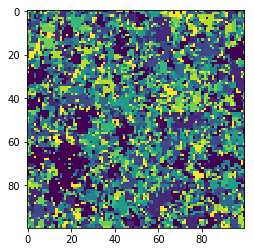

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.52299797e-08]
current no. cols (lambda): 10
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.75340304 0.24659696]
assigned bonds (eta_edges):
[[ 0  1  1 ...  1  1  1]
 [ 1  0  1 ...  0  0  1]
 [ 0  1  1 ...  1  0  1]
 ...
 [ 1  0  0 ...  1  1  0]
 [ 0  1  0 ...  0  0  1]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 0  1  1 ...  1  1 -1]
 [ 1  1  1 ...  1  1 -1]
 [ 1  1  1 ...  1  1 -1]
 ...
 [ 0  0  1 ...  1  1 -1]
 [ 1  0  1 ...  1  1 -1]
 [ 1  1  1 ...  1  0 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.91393119]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10  8 10 ... 10 10 10]
 [10 10  8 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters form

assigned bonds (eta_edges):
[[ 0  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  0  1]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 1  1  1 ...  0  1 -1]
 [ 1  1  1 ...  1  1 -1]
 [ 1  1  1 ...  1  0 -1]
 ...
 [ 0  1  1 ...  1  1 -1]
 [ 1  0  1 ...  1  1 -1]
 [ 0  0  1 ...  1  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.91393119]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters formed by bonds (eta_edge):
[[   1    2    3 ...   96   96   98]
 [   1  100  101 ...  178  180  181]
 [ 182  183  184 ...  261  180  180]
 ...
 [1178 1178 1249 ... 1174 1332 1248]
 [1335 1338 1338 ... 1326 1412 1413]
 [1414 1414 1414 ... 1490 1499 1500]]
Case with field and gamma > 0 or case with gamma = 0
done 

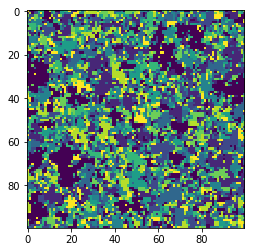

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.52299797e-08]
current no. cols (lambda): 10
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.75340304 0.24659696]
assigned bonds (eta_edges):
[[ 1  1  1 ...  0  1  1]
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  0  1]
 ...
 [ 0  1  1 ...  1  0  1]
 [ 1  1  0 ...  1  0  0]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 1  1  1 ...  1  1 -1]
 [ 1  1  1 ...  1  1 -1]
 [ 1  0  1 ...  1  0 -1]
 ...
 [ 1  0  1 ...  0  1 -1]
 [ 1  1  1 ...  1  1 -1]
 [ 1  1  1 ...  1  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.91393119]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [ 2 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters form

assigned bonds (eta_edges):
[[ 1  1  1 ...  0  1  1]
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  0  1  0]
 ...
 [ 1  1  1 ...  1  1  1]
 [ 1  1  0 ...  1  0  0]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 0  1  1 ...  0  1 -1]
 [ 0  1  1 ...  1  0 -1]
 [ 1  1  1 ...  1  1 -1]
 ...
 [ 0  0  1 ...  1  0 -1]
 [ 0  1  1 ...  1  1 -1]
 [ 1  1  1 ...  0  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.91393119]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [ 2 10 10 ... 10 10 10]]
clusters formed by bonds (eta_edge):
[[   1    1    2 ...   96   96   98]
 [  99   99  101 ...   96  183  183]
 [ 185  186  187 ...  180  275  276]
 ...
 [1237 1237 1237 ... 1233 1235 1235]
 [1415 1415 1416 ... 1504 1505  583]
 [1509 1510 1416 ... 1505 1505  583]]
Case with field and gamma > 0 or case with gamma = 0
done 

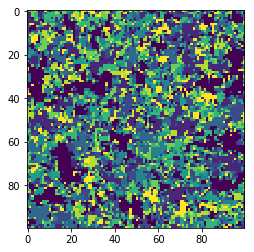

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.52299797e-08]
current no. cols (lambda): 10
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.75340304 0.24659696]
assigned bonds (eta_edges):
[[ 1  1  0 ...  0  1  1]
 [ 0  0  0 ...  1  1  1]
 [ 0  0  1 ...  0  1  0]
 ...
 [ 1  0  1 ...  1  1  1]
 [ 1  1  1 ...  1  0  0]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 1  0  1 ...  1  0 -1]
 [ 0  1  1 ...  1  1 -1]
 [ 0  1  1 ...  1  1 -1]
 ...
 [ 1  1  0 ...  1  0 -1]
 [ 0  1  1 ...  1  1 -1]
 [ 1  1  1 ...  1  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.91393119]
assigned max colors (eta_sites):
[[ 8 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ...  3 10 10]
 [10  9 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters form

assigned bonds (eta_edges):
[[ 1  0  0 ...  1  1  0]
 [ 1  1  1 ...  1  0  0]
 [ 0  1  1 ...  1  1  1]
 ...
 [ 0  0  1 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 0  1  1 ...  1  1 -1]
 [ 0  1  1 ...  0  0 -1]
 [ 1  0  1 ...  1  0 -1]
 ...
 [ 0  1  1 ...  1  1 -1]
 [ 1  1  1 ...  1  1 -1]
 [ 1  1  1 ...  0  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.91393119]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10  3]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters formed by bonds (eta_edge):
[[   1    1    2 ...   92   93  165]
 [   1    1    2 ...  165  165  165]
 [ 166  167  167 ...  243  165  165]
 ...
 [1283 1283 1197 ... 1368 1369 1371]
 [1283 1283 1372 ... 1460 1461 1463]
 [1464 1465 1467 ... 1563 1563 1564]]
Case with field and gamma > 0 or case with gamma = 0
done 

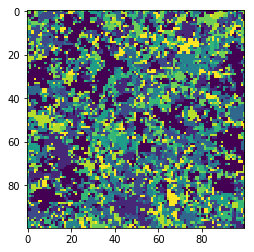

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.52299797e-08]
current no. cols (lambda): 10
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.75340304 0.24659696]
assigned bonds (eta_edges):
[[ 1  0  0 ...  1  1  1]
 [ 1  1  1 ...  1  0  1]
 [ 1  1  1 ...  1  1  0]
 ...
 [ 0  0  1 ...  0  1  1]
 [ 1  1  1 ...  0  0  1]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 0  1  1 ...  1  0 -1]
 [ 0  1  1 ...  0  1 -1]
 [ 0  1  1 ...  1  1 -1]
 ...
 [ 0  1  1 ...  1  1 -1]
 [ 0  1  1 ...  0  1 -1]
 [ 0  1  1 ...  1  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.91393119]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters form

assigned bonds (eta_edges):
[[ 0  1  0 ...  1  1  0]
 [ 0  0  1 ...  1  1  0]
 [ 1  1  1 ...  1  1  1]
 ...
 [ 1  1  1 ...  1  1  1]
 [ 1  0  1 ...  0  0  1]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 1  1  1 ...  1  1 -1]
 [ 0  1  1 ...  1  0 -1]
 [ 1  1  1 ...  0  0 -1]
 ...
 [ 1  1  0 ...  1  1 -1]
 [ 1  0  1 ...  1  1 -1]
 [ 0  1  1 ...  1  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.91393119]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10  7 10 ...  8 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters formed by bonds (eta_edge):
[[   1    2    3 ...   95   96   97]
 [   1    1    3 ...  184   97   97]
 [   1    1  185 ...   97   97   97]
 ...
 [1275 1276  936 ... 1359 1363 2303]
 [1365  154  154 ... 1359 1446 1449]
 [ 154  154 1450 ... 1359 1446 1540]]
Case with field and gamma > 0 or case with gamma = 0
done 

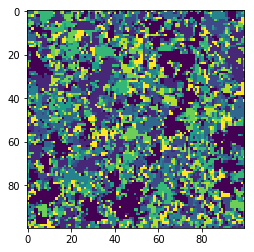

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.52299797e-08]
current no. cols (lambda): 10
assigned no. cols (eta_lambda): 10
probabilities for edges: [0.75340304 0.24659696]
assigned bonds (eta_edges):
[[ 1  0  0 ...  1  1  0]
 [ 1  1  1 ...  0  1  1]
 [ 1  1  1 ...  1  1  1]
 ...
 [ 0  1  0 ...  1  1  1]
 [ 1  1  1 ...  0  1  1]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 0  1  1 ...  1  1 -1]
 [ 1  0  1 ...  1  0 -1]
 [ 0  1  1 ...  1  1 -1]
 ...
 [ 1  1  0 ...  1  1 -1]
 [ 1  0  1 ...  1  1 -1]
 [ 1  1  1 ...  1  0 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.91393119]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]]
clusters form

assigned bonds (eta_edges):
[[ 0  1  1 ...  1  1  1]
 [ 1  1  0 ...  1  1  1]
 [ 0  0  1 ...  1  0  0]
 ...
 [ 1  1  1 ...  0  0  1]
 [ 1  0  1 ...  0  1  1]
 [-1 -1 -1 ... -1 -1 -1]]

[[ 1  1  1 ...  1  1 -1]
 [ 1  1  1 ...  1  1 -1]
 [ 0  1  1 ...  1  1 -1]
 ...
 [ 1  1  1 ...  1  0 -1]
 [ 1  0  1 ...  1  1 -1]
 [ 1  1  1 ...  1  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.91393119]
assigned max colors (eta_sites):
[[10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10 10]
 ...
 [10 10 10 ... 10 10 10]
 [10 10 10 ... 10 10  3]
 [10 10 10 ... 10 10 10]]
clusters formed by bonds (eta_edge):
[[   1    2    3 ...   96   98   99]
 [   1  101  102 ...  174  175  176]
 [ 177  177  102 ...  248  249  249]
 ...
 [1193 1106 1194 ... 1290 1285 1285]
 [1292 1293 1293 ... 1290 1285 1370]
 [1371 1293 1373 ... 1290 1441 1444]]
Case with field and gamma > 0 or case with gamma = 0
done 

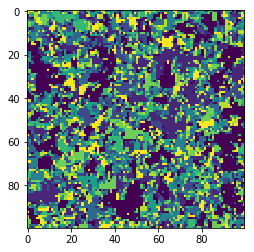

In [11]:
only_averages = False
prt = True
N, no_cols = 100, 10
gamma = 2    # strength of preference for low no. of cols
J = .7        # strength of preference for bonds
alpha = 0.01    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha)

lambda probabilities: [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.52299797e-08]
edge probabilities: [0.83470111 0.16529889]
site probabilities: [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.91393119]

initial config:
[[ 3  8  9 ...  8  2  8]
 [ 1  8  3 ...  5  3  5]
 [10 10  8 ...  7  2  5]
 ...
 [ 4  3  8 ...  7  9  8]
 [ 9  9  1 ...  7  3  8]
 [ 5  3  5 ...  3  2 10]]

-------------------------------------------------- iter 0 --------------------------------------------------


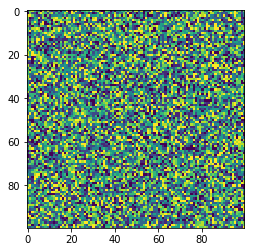


-------------------------------------------------- iter 10 --------------------------------------------------


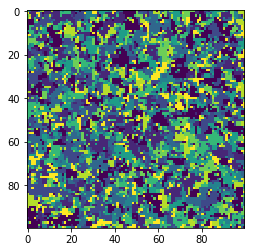


-------------------------------------------------- iter 20 --------------------------------------------------


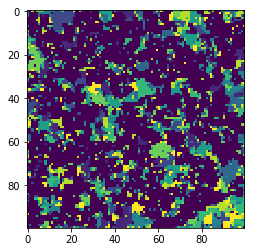


-------------------------------------------------- iter 30 --------------------------------------------------


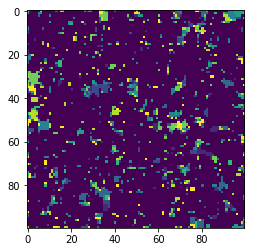


-------------------------------------------------- iter 40 --------------------------------------------------


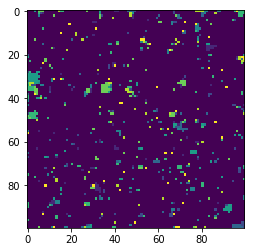


-------------------------------------------------- iter 50 --------------------------------------------------


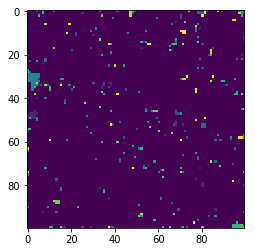


-------------------------------------------------- iter 60 --------------------------------------------------


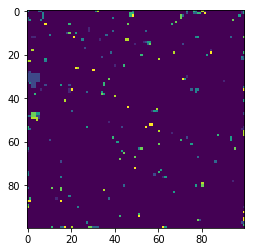


-------------------------------------------------- iter 70 --------------------------------------------------


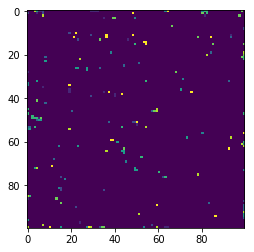


-------------------------------------------------- iter 80 --------------------------------------------------


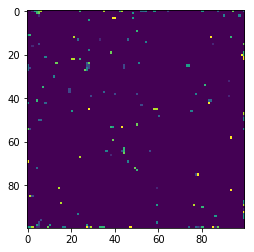


-------------------------------------------------- iter 90 --------------------------------------------------


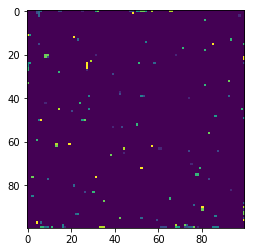


final config:
[[8 1 1 ... 1 1 8]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 5]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


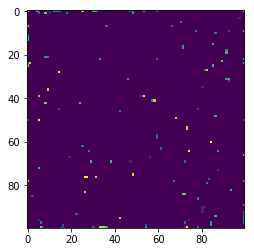

In [15]:
only_averages = False
prt = False
N, no_cols = 100, 10
gamma = 2    # strength of preference for low no. of cols
J = .9        # strength of preference for bonds
alpha = 0.01    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha)

lambda probabilities: [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
edge probabilities: [0.83470111 0.16529889]
site probabilities: [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.00909377 0.00900328 0.0089137
 0.00882501 0.0087372  0.00865026 0.00856419 0.00847897 0.00839461
 0.00831108 0.00822838 0.00814651 0.00806545 0.0079852  0.00790574
 0.00782708 0.0077492  0.00767209 0.00759575 0.00752017 0.00744535
 0.00737126 0.00729792 0.00722

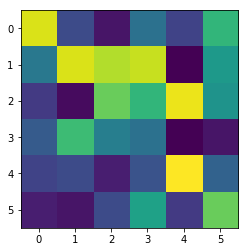

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 24
assigned no. cols (eta_lambda): 24
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [-1 -1 -1 -1 -1 -1]]

[[ 1  1  1  1  1 -1]
 [ 1  1  1  1  1 -1]
 [ 1  1  1  1  1 -1]
 [ 1  1  1  1  1 -1]
 [ 1  1  1  1  1 -1]
 [ 1  1  1  1  1 -1]]
probabiliti

probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  0  1  1  1]
 [-1 -1 -1 -1 -1 -1]]

[[ 1  1  1  1  0 -1]
 [ 1  1  1  1  1 -1]
 [ 1  1  1  1  1 -1]
 [ 1  1  1  1  1 -1]
 [ 0  1  1  1  0 -1]
 [ 1  0  1  1  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.00909377 0.00900328 0.0089137
 0.00882501 0.0087372  0.00865026 0.00856419 0.00847897 0.00839461
 0.00831108 0.00822838 0.00814651 0.00806545 0.0079852  0.00790574
 0.00782708 0.0077492  0.00767209 0.00759575 0.00752017 0.00744535
 0.00737126 0.00729792 0.0072253  0.00715341 0.00708223 0.70468809]
assigned max colors (eta_sites):
[[36 34 36 36 36 36]
 [36 36 36 36 36 36]
 [36 36 17 36 36 33]
 [36 36 36 36 36 36]
 [32 36 36 36 36 36]
 [36 36 36 36 36 36]]
clusters formed by bonds (eta_edge):
[[ 1  2  3  4  5  5]
 [ 6  7  8  9 

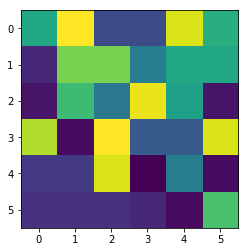

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 20
assigned no. cols (eta_lambda): 20
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [-1 -1 -1 -1 -1 -1]]

[[ 1  1  1  1  1 -1]
 [ 1  0  1  1  0 -1]
 [ 1  1  1  1  1 -1]
 [ 1  1  1  0  1 -1]
 [ 0  1  1  1  1 -1]
 [ 1  0  1  1  1 -1]]
probabiliti

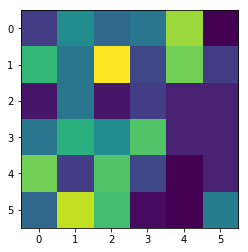

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 18
assigned no. cols (eta_lambda): 18
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 1  1  1  1  1  1]
 [ 1  0  1  1  1  1]
 [ 1  1  1  1  0  0]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  0  1]
 [-1 -1 -1 -1 -1 -1]]

[[ 1  1  1  1  1 -1]
 [ 1  1  1  1  1 -1]
 [ 1  1  1  1  0 -1]
 [ 1  1  1  1  0 -1]
 [ 1  1  1  1  1 -1]
 [ 1  1  1  1  1 -1]]
probabiliti

probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 1  1  1  1  1  1]
 [ 1  0  1  1  1  1]
 [ 1  1  1  1  0  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [-1 -1 -1 -1 -1 -1]]

[[ 1  1  1  1  1 -1]
 [ 1  1  1  1  1 -1]
 [ 1  1  0  1  0 -1]
 [ 1  1  1  0  0 -1]
 [ 1  0  1  1  1 -1]
 [ 1  1  0  1  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.00909377 0.00900328 0.0089137
 0.00882501 0.0087372  0.00865026 0.00856419 0.00847897 0.00839461
 0.00831108 0.00822838 0.00814651 0.00806545 0.0079852  0.00790574
 0.00782708 0.0077492  0.00767209 0.00759575 0.00752017 0.00744535
 0.00737126 0.00729792 0.0072253  0.00715341 0.00708223 0.70468809]
assigned max colors (eta_sites):
[[36 36 36 31 36 36]
 [36 36 36 36 23 36]
 [36 36 36 25 36 36]
 [36 36 36 36 36 36]
 [36 36 29 36 36 36]
 [36 36 36 36 36 36]]
clusters formed by bonds (eta_edge):
[[ 1  2  3  4  5  6]
 [ 7  8  9 10 

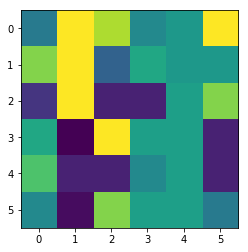

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 14
assigned no. cols (eta_lambda): 15
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 1  0  1  1  0  1]
 [ 1  0  1  1  1  1]
 [ 1  1  1  1  0  1]
 [ 1  1  1  1  0  0]
 [ 1  1  1  1  0  1]
 [-1 -1 -1 -1 -1 -1]]

[[ 1  1  1  1  1 -1]
 [ 1  1  1  1  0 -1]
 [ 1  1  0  1  1 -1]
 [ 1  1  1  0  1 -1]
 [ 1  1  1  1  1 -1]
 [ 1  1  1  0  1 -1]]
probabiliti

assigned no. cols (eta_lambda): 14
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 1  1  1  1  0  1]
 [ 1  0  0  1  1  0]
 [ 1  1  1  1  0  1]
 [ 1  1  1  1  0  0]
 [ 1  1  1  1  1  1]
 [-1 -1 -1 -1 -1 -1]]

[[ 1  1  1  1  1 -1]
 [ 1  1  1  1  0 -1]
 [ 1  1  0  1  1 -1]
 [ 1  1  0  1  1 -1]
 [ 1  1  1  1  1 -1]
 [ 1  1  1  0  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.00909377 0.00900328 0.0089137
 0.00882501 0.0087372  0.00865026 0.00856419 0.00847897 0.00839461
 0.00831108 0.00822838 0.00814651 0.00806545 0.0079852  0.00790574
 0.00782708 0.0077492  0.00767209 0.00759575 0.00752017 0.00744535
 0.00737126 0.00729792 0.0072253  0.00715341 0.00708223 0.70468809]
assigned max colors (eta_sites):
[[36 36 36 36 36 36]
 [36 36 36 36 36  4]
 [36 36 36 36 36 36]
 [36 36 36 36 36 36]
 [36 36  5 36 36 36]
 [36 36 18 36 36 36]]
clusters formed by bonds (eta_edge):


probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 1  1  0  1  0  1]
 [ 1  0  0  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  0  1  0  0]
 [ 1  1  1  1  1  0]
 [-1 -1 -1 -1 -1 -1]]

[[ 0  0  1  1  1 -1]
 [ 1  1  1  1  1 -1]
 [ 0  1  1  1  1 -1]
 [ 1  1  0  1  1 -1]
 [ 1  1  1  1  0 -1]
 [ 1  1  1  1  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.00909377 0.00900328 0.0089137
 0.00882501 0.0087372  0.00865026 0.00856419 0.00847897 0.00839461
 0.00831108 0.00822838 0.00814651 0.00806545 0.0079852  0.00790574
 0.00782708 0.0077492  0.00767209 0.00759575 0.00752017 0.00744535
 0.00737126 0.00729792 0.0072253  0.00715341 0.00708223 0.70468809]
assigned max colors (eta_sites):
[[20 36 36  7 36 36]
 [36 36 28 36 36 36]
 [36 36 36 17 36 36]
 [36 36 36 36 36 21]
 [36 36 36 36 36 36]
 [21 36 36 36 16 36]]
clusters formed by bonds (eta_edge):
[[ 1  1  1  2  3  4]
 [ 5  6  1  7 

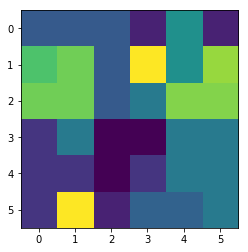

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 12
assigned no. cols (eta_lambda): 12
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 1  1  0  1  0  1]
 [ 1  0  0  1  1  1]
 [ 1  1  1  1  1  1]
 [ 0  1  0  1  0  0]
 [ 0  1  1  1  1  0]
 [-1 -1 -1 -1 -1 -1]]

[[ 0  1  1  1  1 -1]
 [ 1  1  1  1  1 -1]
 [ 0  1  1  1  0 -1]
 [ 1  1  0  1  0 -1]
 [ 0  1  1  1  0 -1]
 [ 1  1  1  0  1 -1]]
probabiliti

probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 1  0  1  1  0  1]
 [ 0  0  0  1  1  1]
 [ 1  0  0  1  0  1]
 [ 1  1  1  0  0  1]
 [ 0  1  1  1  1  0]
 [-1 -1 -1 -1 -1 -1]]

[[ 1  1  1  1  1 -1]
 [ 0  0  0  1  0 -1]
 [ 0  0  1  0  1 -1]
 [ 1  0  0  1  0 -1]
 [ 1  1  0  1  1 -1]
 [ 1  1  1  0  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.00909377 0.00900328 0.0089137
 0.00882501 0.0087372  0.00865026 0.00856419 0.00847897 0.00839461
 0.00831108 0.00822838 0.00814651 0.00806545 0.0079852  0.00790574
 0.00782708 0.0077492  0.00767209 0.00759575 0.00752017 0.00744535
 0.00737126 0.00729792 0.0072253  0.00715341 0.00708223 0.70468809]
assigned max colors (eta_sites):
[[36 32 36 33 36 36]
 [36 36 36 36 36 36]
 [32 36  8 36 36 36]
 [36 36 29 14 36 36]
 [36 36 36 36 36 36]
 [36 36 36 36 33 36]]
clusters formed by bonds (eta_edge):
[[ 1  7  3  4  5  6]
 [ 7  7  7  7 

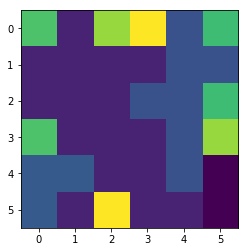

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 8
assigned no. cols (eta_lambda): 8
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 1  0  1  1  0  1]
 [ 0  0  0  1  0  1]
 [ 1  0  1  1  1  1]
 [ 1  1  0  0  0  1]
 [ 0  1  1  0  1  0]
 [-1 -1 -1 -1 -1 -1]]

[[ 1  1  1  1  1 -1]
 [ 0  0  0  1  0 -1]
 [ 0  0  1  1  1 -1]
 [ 1  1  1  1  1 -1]
 [ 0  1  0  1  1 -1]
 [ 1  1  1  0  1 -1]]
probabilities

retried sample (too many colors) 12266 times
config:
[[ 5  5 20 24 29 13]
 [ 5  5  5 33 29  5]
 [ 5  5  5 33 29 31]
 [24  5  5  5  4  4]
 [24  5  5  5  5 20]
 [24 29 29  5 24 20]]
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 8
assigned no. cols (eta_lambda): 8
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 0  0  1  1  0  1]
 [ 0  0  0  0  0  1]
 [ 1  0  1  1  1  1]
 [ 0  0  0  0  1  1]
 [ 0

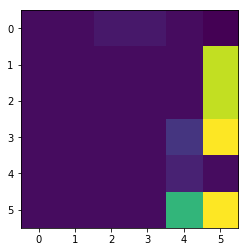

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 8
assigned no. cols (eta_lambda): 8
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 0  0  1  1  1  1]
 [ 0  1  0  0  1  0]
 [ 0  0  0  0  1  1]
 [ 0  1  0  0  1  1]
 [ 0  0  1  0  1  1]
 [-1 -1 -1 -1 -1 -1]]

[[ 0  1  0  1  1 -1]
 [ 0  0  0  0  1 -1]
 [ 0  0  0  0  1 -1]
 [ 0  0  0  1  1 -1]
 [ 0  0  0  1  1 -1]
 [ 0  0  0  1  1 -1]]
probabilities

assigned bonds (eta_edges):
[[ 0  0  0  1  1  1]
 [ 0  0  0  1  0  1]
 [ 0  0  0  0  1  1]
 [ 0  0  0  0  1  1]
 [ 0  0  0  0  1  1]
 [-1 -1 -1 -1 -1 -1]]

[[ 0  0  0  0  1 -1]
 [ 0  0  1  1  1 -1]
 [ 0  0  1  0  1 -1]
 [ 0  0  0  1  1 -1]
 [ 0  1  0  0  1 -1]
 [ 1  0  1  1  0 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.00909377 0.00900328 0.0089137
 0.00882501 0.0087372  0.00865026 0.00856419 0.00847897 0.00839461
 0.00831108 0.00822838 0.00814651 0.00806545 0.0079852  0.00790574
 0.00782708 0.0077492  0.00767209 0.00759575 0.00752017 0.00744535
 0.00737126 0.00729792 0.0072253  0.00715341 0.00708223 0.70468809]
assigned max colors (eta_sites):
[[21 22 36 33 36 36]
 [36 36 36 25 36 36]
 [36 36 36 32 28 36]
 [36 36 36 36 34 36]
 [36 17 10 16 36 36]
 [36 27 33 36 36 36]]
clusters formed by bonds (eta_edge):
[[1 1 1 1 1 3]
 [1 1 1 4 1 5]
 [1 1 1 1 1 6]
 [1 1 1 1 7 8]
 [1 1 1 1 1 9]
 [1 1 1 1

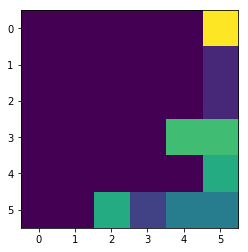

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 7
assigned no. cols (eta_lambda): 8
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 0  0  0  0  0  1]
 [ 0  0  0  0  1  0]
 [ 0  0  0  1  1  1]
 [ 0  0  0  0  1  1]
 [ 0  0  1  1  1  1]
 [-1 -1 -1 -1 -1 -1]]

[[ 0  0  0  0  1 -1]
 [ 0  0  1  0  1 -1]
 [ 0  0  0  0  1 -1]
 [ 0  0  0  1  1 -1]
 [ 0  0  0  0  1 -1]
 [ 0  1  1  1  0 -1]]
probabilities

retried sample (too many colors) 668 times
config:
[[ 1  1  1  1  1 36]
 [ 1  1  1  1  1 24]
 [ 1  1  1  1  1 34]
 [36  1  1 34 14 34]
 [ 1  1  1  1  1 36]
 [ 1  1 34  5 24 26]]
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 7
assigned no. cols (eta_lambda): 7
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 0  0  0  0  0  1]
 [ 0  0  1  0  0  1]
 [ 1  0  0  1  1  0]
 [ 1  0  0  1  1  1]
 [ 0  

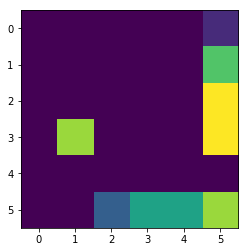

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 7
assigned no. cols (eta_lambda): 8
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 0  0  0  0  0  1]
 [ 0  0  0  0  0  1]
 [ 0  1  1  1  0  0]
 [ 0  1  0  0  0  1]
 [ 0  0  1  1  1  1]
 [-1 -1 -1 -1 -1 -1]]

[[ 0  0  0  0  1 -1]
 [ 0  1  0  0  1 -1]
 [ 0  0  0  0  1 -1]
 [ 1  1  1  0  1 -1]
 [ 1  0  0  0  0 -1]
 [ 0  1  1  0  1 -1]]
probabilities

[[13 36 36 36 36 36]
 [36 36 36 36 36 36]
 [36 36 36 23 36 36]
 [36 36 36 36 36 36]
 [36 36 36 36 36 36]
 [25 17 36 36 36 16]]
clusters formed by bonds (eta_edge):
[[ 1  2  3  3  3  6]
 [ 3  3  3  3  3  8]
 [ 3  3  3  3  9 10]
 [ 3 11  3  3  3 10]
 [ 3  3  3  3  3 12]
 [ 3  3  4  5  5  7]]
retried sample (too many colors) 41 times
config:
[[ 6 20  8  8  8  6]
 [ 8  8  8  8  8 15]
 [ 8  8  8  8 36 33]
 [ 8 33  8  8  8 33]
 [ 8  8  8  8  8 11]
 [ 8  8 15  7  7 11]]
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1

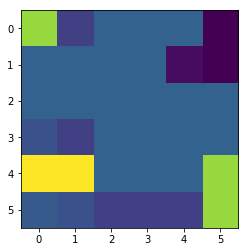

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 8
assigned no. cols (eta_lambda): 8
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 1  1  0  0  1  1]
 [ 0  0  0  0  1  1]
 [ 1  1  0  0  0  0]
 [ 1  1  0  1  1  1]
 [ 1  1  1  1  1  0]
 [-1 -1 -1 -1 -1 -1]]

[[ 1  1  0  0  1 -1]
 [ 1  0  1  1  1 -1]
 [ 0  0  0  1  0 -1]
 [ 1  1  0  0  0 -1]
 [ 0  1  0  1  1 -1]
 [ 1  1  1  0  1 -1]]
probabilities

[[36  6 36 14 36 36]
 [36 36 36 36 28  7]
 [36 36 36 36 36 11]
 [36 36 36 36 36 12]
 [36 36 31 11 36 36]
 [36 36 36 36 36 36]]
clusters formed by bonds (eta_edge):
[[ 1  2  2  2  2  3]
 [ 2  2  2  2  4  5]
 [ 2  2  2  2  2  2]
 [ 6  7  2  2  2  2]
 [ 8  9  2  2 10 10]
 [ 9  9  9  2  2 10]]
retried sample (too many colors) 5 times
config:
[[12  1  1  1  1  7]
 [ 1  1  1  1 10  6]
 [ 1  1  1  1  1  1]
 [35  1  1  1  1  1]
 [18  6  1  1  7  7]
 [ 6  6  6  1  1  7]]
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.

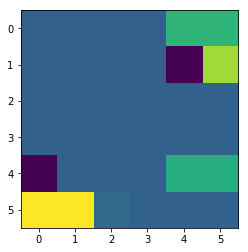

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 7
assigned no. cols (eta_lambda): 7
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 0  1  1  0  1  1]
 [ 0  0  0  0  1  1]
 [ 1  0  0  0  0  0]
 [ 1  1  0  0  1  1]
 [ 1  1  1  1  1  1]
 [-1 -1 -1 -1 -1 -1]]

[[ 0  0  1  1  0 -1]
 [ 1  0  0  1  1 -1]
 [ 0  1  0  0  0 -1]
 [ 0  1  0  0  0 -1]
 [ 1  0  0  1  0 -1]
 [ 0  1  1  0  0 -1]]
probabilities

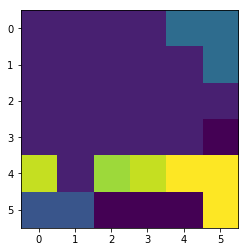

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 7
assigned no. cols (eta_lambda): 7
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 0  0  0  0  1  0]
 [ 1  0  0  0  1  1]
 [ 0  0  0  0  0  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  0]
 [-1 -1 -1 -1 -1 -1]]

[[ 0  0  0  1  0 -1]
 [ 0  0  0  0  1 -1]
 [ 0  0  1  0  0 -1]
 [ 1  0  1  1  1 -1]
 [ 1  1  1  1  0 -1]
 [ 0  1  0  0  1 -1]]
probabilities

retried sample (too many colors) 261 times
config:
[[ 1  1  1  1  1 10]
 [22  1  1  1  1  1]
 [ 7  7  1  1  1  1]
 [ 7  7  7  1  1  1]
 [22  7 17  1  1  1]
 [ 1 12  1 10  7  1]]
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 6
assigned no. cols (eta_lambda): 6
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 1  0  0  0  0  1]
 [ 1  1  0  0  0  1]
 [ 1  0  1  1  0  0]
 [ 1  1  1  0  0  0]
 [ 1  

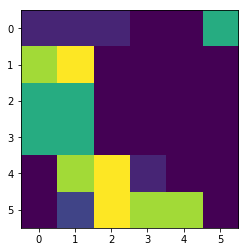

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 6
assigned no. cols (eta_lambda): 6
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 1  1  1  0  0  1]
 [ 1  1  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 1  1  1  1  0  0]
 [ 0  1  0  1  1  0]
 [-1 -1 -1 -1 -1 -1]]

[[ 1  0  1  0  1 -1]
 [ 1  1  0  0  0 -1]
 [ 0  1  0  1  0 -1]
 [ 1  1  0  0  0 -1]
 [ 1  1  1  1  0 -1]
 [ 1  1  1  1  1 -1]]
probabilities

assigned bonds (eta_edges):
[[ 1  1  1  0  0  0]
 [ 1  1  1  0  0  0]
 [ 1  0  1  0  0  0]
 [ 1  1  1  0  0  0]
 [ 1  0  0  0  1  1]
 [-1 -1 -1 -1 -1 -1]]

[[ 1  1  1  0  1 -1]
 [ 0  1  0  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 1  1  1  0  0 -1]
 [ 1  1  1  1  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.00909377 0.00900328 0.0089137
 0.00882501 0.0087372  0.00865026 0.00856419 0.00847897 0.00839461
 0.00831108 0.00822838 0.00814651 0.00806545 0.0079852  0.00790574
 0.00782708 0.0077492  0.00767209 0.00759575 0.00752017 0.00744535
 0.00737126 0.00729792 0.0072253  0.00715341 0.00708223 0.70468809]
assigned max colors (eta_sites):
[[36 36 36 36 36 36]
 [25 36 36 36 36 24]
 [36 36 34 36 36 36]
 [29 36 36 36 36 36]
 [36 36 36 36 36 36]
 [31 36 36 36 36 36]]
clusters formed by bonds (eta_edge):
[[ 1  2  3  4  4  4]
 [ 7  7  4  4  4  4]
 [ 4  4  4  4  4  4]
 [ 4  4  4  4  4  4]


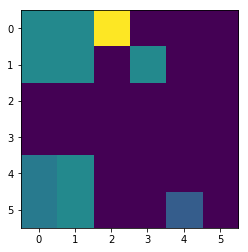

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 5
assigned no. cols (eta_lambda): 5
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 0  0  1  1  0  0]
 [ 1  1  1  1  0  0]
 [ 0  0  0  0  0  0]
 [ 1  1  0  0  1  0]
 [ 0  0  0  0  1  1]
 [-1 -1 -1 -1 -1 -1]]

[[ 0  1  1  0  0 -1]
 [ 1  1  1  1  0 -1]
 [ 0  0  0  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 1  1  0  0  0 -1]
 [ 1  1  0  1  1 -1]]
probabilities

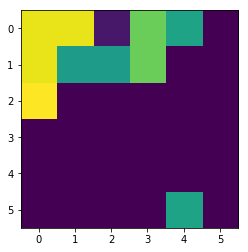

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 7
assigned no. cols (eta_lambda): 7
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 0  1  1  1  1  0]
 [ 1  1  1  1  0  1]
 [ 1  0  1  1  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  1  0]
 [-1 -1 -1 -1 -1 -1]]

[[ 0  1  1  1  1 -1]
 [ 1  1  1  1  1 -1]
 [ 1  0  1  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 0  1  0  0  0 -1]
 [ 0  0  0  1  1 -1]]
probabilities

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 6
assigned no. cols (eta_lambda): 6
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 0  1  1  1  1  1]
 [ 1  0  0  1  1  1]
 [ 0  0  0  0  0  0]
 [ 0  1  0  0  1  0]
 [ 0  0  0  1  1  0]
 [-1 -1 -1 -1 -1 -1]]

[[ 1  1  1  0  0 -1]
 [ 1  0  1  1  0 -1]
 [ 0  0  0  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 1  0  0  0  0 -1]
 [ 0  0  1  1  1 -1]]
probabilities

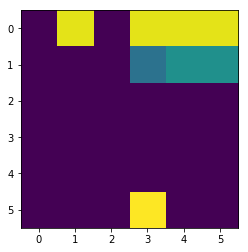

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 5
assigned no. cols (eta_lambda): 5
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 0  1  1  1  1  1]
 [ 0  0  0  1  1  1]
 [ 0  0  0  0  0  0]
 [ 0  0  1  0  0  0]
 [ 0  0  0  1  0  0]
 [-1 -1 -1 -1 -1 -1]]

[[ 1  1  1  0  0 -1]
 [ 1  0  1  1  0 -1]
 [ 0  0  0  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 1  0  0  1  0 -1]
 [ 0  0  1  1  0 -1]]
probabilities

retried sample (too many colors) 0 times
config:
[[ 1  1  1 22  2 23]
 [ 1  1  1  5  5 23]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]
 [ 1  1  1  1  1  1]]
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 5
assigned no. cols (eta_lambda): 5
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 0  0  0  1  1  0]
 [ 0  0  0  1  1  1]
 [ 0  1  0  1  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0 

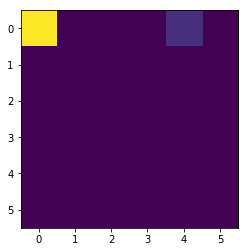

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 3
assigned no. cols (eta_lambda): 3
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 1  0  0  0  1  1]
 [ 1  0  0  1  0  0]
 [ 0  1  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 1  0  0  1  0  0]
 [-1 -1 -1 -1 -1 -1]]

[[ 1  0  0  1  1 -1]
 [ 0  0  1  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 0  0  0  0  1 -1]
 [ 0  1  1  0  0 -1]
 [ 0  1  0  0  1 -1]]
probabilities

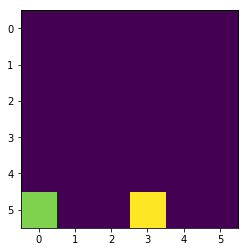

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 3
assigned no. cols (eta_lambda): 3
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 0  0  0  0  0  0]
 [ 1  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 1  0  0  1  0  1]
 [-1 -1 -1 -1 -1 -1]]

[[ 1  0  0  0  0 -1]
 [ 0  0  0  1  0 -1]
 [ 0  0  0  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 1  0  1  1  1 -1]]
probabilities

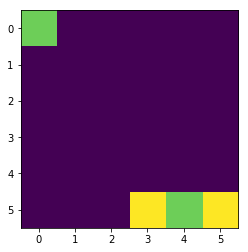

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 3
assigned no. cols (eta_lambda): 3
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 1  0  0  0  0  0]
 [ 0  1  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 1  0  1  0  0  1]
 [ 0  0  0  1  1  1]
 [-1 -1 -1 -1 -1 -1]]

[[ 1  0  0  1  0 -1]
 [ 0  0  0  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 1  1  1  0  0 -1]
 [ 0  0  1  1  1 -1]]
probabilities

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 2
assigned no. cols (eta_lambda): 2
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 0  0  1  1  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  1]
 [ 0  0  1  1  1  0]
 [-1 -1 -1 -1 -1 -1]]

[[ 0  0  0  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 0  1  0  0  0 -1]
 [ 0  1  0  0  0 -1]
 [ 1  0  0  0  0 -1]
 [ 0  0  1  1  1 -1]]
probabilities

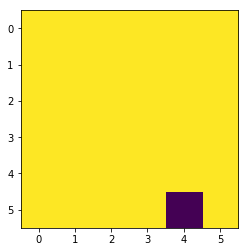

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 2
assigned no. cols (eta_lambda): 2
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 1  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 1  0  1  0  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  1  0]
 [-1 -1 -1 -1 -1 -1]]

[[ 1  0  0  0  0 -1]
 [ 0  0  0  1  0 -1]
 [ 0  0  0  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 0  1  1  0  1 -1]
 [ 0  0  0  1  1 -1]]
probabilities

 [ 0  0  0  0  0 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.00909377 0.00900328 0.0089137
 0.00882501 0.0087372  0.00865026 0.00856419 0.00847897 0.00839461
 0.00831108 0.00822838 0.00814651 0.00806545 0.0079852  0.00790574
 0.00782708 0.0077492  0.00767209 0.00759575 0.00752017 0.00744535
 0.00737126 0.00729792 0.0072253  0.00715341 0.00708223 0.70468809]
assigned max colors (eta_sites):
[[36 28 36 36 36 36]
 [36  7 36 30 36 33]
 [36 36 36 36 27 36]
 [16 36 15 36 36 36]
 [36 36 36 36 36 36]
 [36 36 36 36 36 36]]
clusters formed by bonds (eta_edge):
[[1 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]]
retried sample (too many colors) 0 times
config:
[[31  7  7  7  7  7]
 [ 7  7  7  7  7  7]
 [ 7  7  7  7  7  7]
 [ 7  7  7  7  7  7]
 [ 7  7  7  7  7  7]
 [ 7  7  7  7  7  7]]
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.583

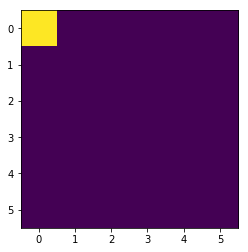

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 2
assigned no. cols (eta_lambda): 2
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 1  0  0  0  0  1]
 [ 0  0  1  0  0  0]
 [ 0  0  0  1  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  1  0  0  1]
 [-1 -1 -1 -1 -1 -1]]

[[ 1  0  0  0  0 -1]
 [ 0  0  0  0  1 -1]
 [ 1  1  0  0  0 -1]
 [ 0  1  0  0  0 -1]
 [ 1  0  0  1  0 -1]
 [ 1  0  0  0  1 -1]]
probabilities

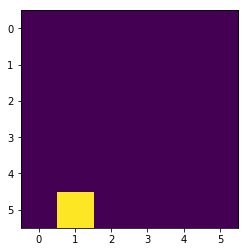

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 2
assigned no. cols (eta_lambda): 2
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 0  0  0  0  0  0]
 [ 1  0  0  0  0  0]
 [ 1  0  1  0  0  0]
 [ 1  0  0  0  0  0]
 [ 0  1  0  0  1  0]
 [-1 -1 -1 -1 -1 -1]]

[[ 0  0  0  0  1 -1]
 [ 0  0  0  0  0 -1]
 [ 0  0  1  0  0 -1]
 [ 0  1  0  0  0 -1]
 [ 0  0  0  0  1 -1]
 [ 1  1  0  0  0 -1]]
probabilities

probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 0  0  1  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  1  1]
 [ 0  0  0  0  0  1]
 [ 0  1  0  0  1  0]
 [-1 -1 -1 -1 -1 -1]]

[[ 0  0  1  0  0 -1]
 [ 0  0  0  1  1 -1]
 [ 0  0  0  0  0 -1]
 [ 0  0  0  0  1 -1]
 [ 0  1  0  1  1 -1]
 [ 1  1  1  0  0 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.00909377 0.00900328 0.0089137
 0.00882501 0.0087372  0.00865026 0.00856419 0.00847897 0.00839461
 0.00831108 0.00822838 0.00814651 0.00806545 0.0079852  0.00790574
 0.00782708 0.0077492  0.00767209 0.00759575 0.00752017 0.00744535
 0.00737126 0.00729792 0.0072253  0.00715341 0.00708223 0.70468809]
assigned max colors (eta_sites):
[[36 36  7 36 11 36]
 [36 36 36 36 36 32]
 [ 6 36  6 36 36 36]
 [36 17 36 36 21 36]
 [ 9 36 22  5 36 36]
 [36 36 10  7  5 36]]
clusters formed by bonds (eta_edge):
[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1

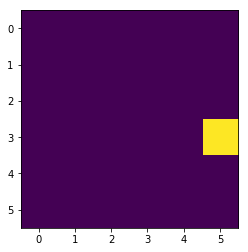

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 2
assigned no. cols (eta_lambda): 3
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 1  0  0  0  1  1]
 [ 0  1  1  0  0  0]
 [ 0  0  0  0  0  1]
 [ 1  0  0  0  0  1]
 [ 0  0  0  0  0  0]
 [-1 -1 -1 -1 -1 -1]]

[[ 0  0  1  0  1 -1]
 [ 0  0  0  0  1 -1]
 [ 0  1  0  0  0 -1]
 [ 0  0  0  0  1 -1]
 [ 0  1  0  0  1 -1]
 [ 0  0  0  0  0 -1]]
probabilities

probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.00909377 0.00900328 0.0089137
 0.00882501 0.0087372  0.00865026 0.00856419 0.00847897 0.00839461
 0.00831108 0.00822838 0.00814651 0.00806545 0.0079852  0.00790574
 0.00782708 0.0077492  0.00767209 0.00759575 0.00752017 0.00744535
 0.00737126 0.00729792 0.0072253  0.00715341 0.00708223 0.70468809]
assigned max colors (eta_sites):
[[14 36 36 36 36 36]
 [36 36 36 36 36 36]
 [36 36 36 36 36 36]
 [22 16 36 36 36 36]
 [35 36 36 29 36 36]
 [36 36 36 36 36 36]]
clusters formed by bonds (eta_edge):
[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 2]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]]
retried sample (too many colors) 0 times
config:
[[ 7  7  7  7  7  7]
 [ 7  7  7  7  7  7]
 [ 7  7  7  7  7  7]
 [ 7  7  7  7  7 26]
 [ 7  7  7  7  7  7]
 [ 7  7  7  7  7  7]]
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-

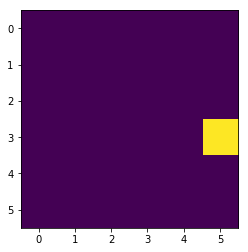

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 2
assigned no. cols (eta_lambda): 2
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 1  0  0  0  0  1]
 [ 0  0  0  0  0  1]
 [ 0  0  1  1  1  0]
 [-1 -1 -1 -1 -1 -1]]

[[ 0  0  0  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 0  0  0  0  1 -1]
 [ 0  0  1  0  0 -1]
 [ 1  0  0  0  0 -1]]
probabilities

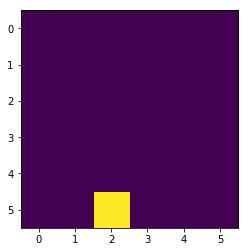

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 2
assigned no. cols (eta_lambda): 2
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 1  0  0  0  0  0]
 [ 0  1  1  0  0  0]
 [ 1  0  0  0  0  0]
 [ 0  0  0  1  0  1]
 [ 0  0  1  0  1  0]
 [-1 -1 -1 -1 -1 -1]]

[[ 0  0  0  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 1  0  0  0  1 -1]
 [ 0  0  0  0  0 -1]
 [ 0  1  0  0  1 -1]
 [ 0  1  1  1  0 -1]]
probabilities

 [ 0  0  0  0  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.00909377 0.00900328 0.0089137
 0.00882501 0.0087372  0.00865026 0.00856419 0.00847897 0.00839461
 0.00831108 0.00822838 0.00814651 0.00806545 0.0079852  0.00790574
 0.00782708 0.0077492  0.00767209 0.00759575 0.00752017 0.00744535
 0.00737126 0.00729792 0.0072253  0.00715341 0.00708223 0.70468809]
assigned max colors (eta_sites):
[[36 36 36 33 36 36]
 [36 36 36 36 36 31]
 [36 36 36 20 36  7]
 [36  6 13 36 36 36]
 [36 33 36 36 36 36]
 [36 13 36 36 21 36]]
clusters formed by bonds (eta_edge):
[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]]
retried sample (too many colors) 0 times
config:
[[6 6 6 6 6 6]
 [6 6 6 6 6 6]
 [6 6 6 6 6 6]
 [6 6 6 6 6 6]
 [6 6 6 6 6 6]
 [6 6 6 6 6 6]]
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698

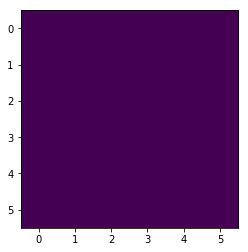

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 1
assigned no. cols (eta_lambda): 1
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 1  1  0  0  0  0]
 [-1 -1 -1 -1 -1 -1]]

[[ 1  0  1  0  0 -1]
 [ 0  0  0  1  0 -1]
 [ 0  0  1  0  0 -1]
 [ 1  0  1  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 1  0  0  0  0 -1]]
probabilities

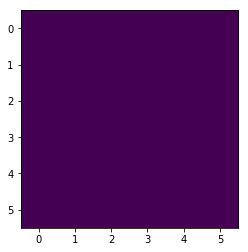

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 1
assigned no. cols (eta_lambda): 1
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 1  1  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 1  1  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  1]
 [-1 -1 -1 -1 -1 -1]]

[[ 0  0  1  0  0 -1]
 [ 0  0  0  1  0 -1]
 [ 1  0  0  0  1 -1]
 [ 0  0  0  0  0 -1]
 [ 0  1  0  0  0 -1]
 [ 0  1  0  0  1 -1]]
probabilities

assigned bonds (eta_edges):
[[ 1  1  0  0  0  0]
 [ 0  1  0  0  0  0]
 [ 0  0  0  0  0  1]
 [ 0  1  0  1  0  0]
 [ 0  0  0  0  0  1]
 [-1 -1 -1 -1 -1 -1]]

[[ 1  1  0  1  0 -1]
 [ 0  1  0  1  0 -1]
 [ 0  1  0  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 1  0  0  0  0 -1]
 [ 0  0  0  0  0 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.00909377 0.00900328 0.0089137
 0.00882501 0.0087372  0.00865026 0.00856419 0.00847897 0.00839461
 0.00831108 0.00822838 0.00814651 0.00806545 0.0079852  0.00790574
 0.00782708 0.0077492  0.00767209 0.00759575 0.00752017 0.00744535
 0.00737126 0.00729792 0.0072253  0.00715341 0.00708223 0.70468809]
assigned max colors (eta_sites):
[[36 36 36 36 36 21]
 [36 36 24 36 36  9]
 [36 36 36 31 36 36]
 [36 31 36 36 36 36]
 [ 4 36 36  6 36 22]
 [36 36 36 10 34 36]]
clusters formed by bonds (eta_edge):
[[1 2 3 3 3 3]
 [3 3 3 3 3 3]
 [3 3 3 3 3 3]
 [3 3 3 3 3 3]
 [3 3 3 3 3 3]
 [3 3 3 3

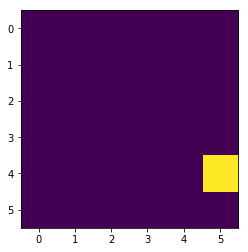

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 2
assigned no. cols (eta_lambda): 2
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 0  1  0  0  0  1]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  1]
 [ 0  0  0  0  0  1]
 [-1 -1 -1 -1 -1 -1]]

[[ 1  0  0  1  0 -1]
 [ 0  0  0  1  0 -1]
 [ 0  0  0  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 1  0  0  0  1 -1]
 [ 0  0  0  0  0 -1]]
probabilities

assigned no. cols (eta_lambda): 2
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 0  0  0  0  0  1]
 [ 0  0  1  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  1  0]
 [ 1  0  0  0  0  0]
 [-1 -1 -1 -1 -1 -1]]

[[ 0  0  0  0  1 -1]
 [ 1  0  0  0  1 -1]
 [ 0  0  0  0  0 -1]
 [ 0  1  0  0  0 -1]
 [ 1  0  0  0  0 -1]
 [ 1  0  0  0  0 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.00909377 0.00900328 0.0089137
 0.00882501 0.0087372  0.00865026 0.00856419 0.00847897 0.00839461
 0.00831108 0.00822838 0.00814651 0.00806545 0.0079852  0.00790574
 0.00782708 0.0077492  0.00767209 0.00759575 0.00752017 0.00744535
 0.00737126 0.00729792 0.0072253  0.00715341 0.00708223 0.70468809]
assigned max colors (eta_sites):
[[36 36  8 36 36 18]
 [36 35 36 36 36 36]
 [36 36 36 36 36 36]
 [36 36  9 25 36 36]
 [20 36 36 36 35 36]
 [36 36 36 36 14 36]]
clusters formed by bonds (eta_edge):
[

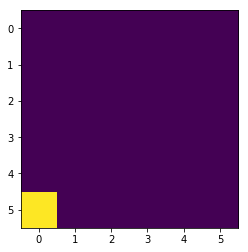

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 2
assigned no. cols (eta_lambda): 2
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 1  0  0  0  0  0]
 [ 1  0  0  0  0  0]
 [-1 -1 -1 -1 -1 -1]]

[[ 0  0  1  0  0 -1]
 [ 1  0  0  1  0 -1]
 [ 0  0  0  1  0 -1]
 [ 1  0  0  1  1 -1]
 [ 0  0  0  1  0 -1]
 [ 1  1  1  0  0 -1]]
probabilities

assigned no. cols (eta_lambda): 2
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 0  0  0  0  0  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  1  0]
 [ 0  0  0  0  0  0]
 [ 0  0  0  0  1  0]
 [-1 -1 -1 -1 -1 -1]]

[[ 0  0  1  1  0 -1]
 [ 0  0  0  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 0  1  0  0  1 -1]]
probabilities for colors (sites): [0.00995017 0.00985116 0.00975314 0.00965609 0.00956001 0.00946489
 0.00937071 0.00927747 0.00918516 0.00909377 0.00900328 0.0089137
 0.00882501 0.0087372  0.00865026 0.00856419 0.00847897 0.00839461
 0.00831108 0.00822838 0.00814651 0.00806545 0.0079852  0.00790574
 0.00782708 0.0077492  0.00767209 0.00759575 0.00752017 0.00744535
 0.00737126 0.00729792 0.0072253  0.00715341 0.00708223 0.70468809]
assigned max colors (eta_sites):
[[36 21 25  7 36 36]
 [36 30 12 20 36 36]
 [36 36 36 36 36 36]
 [36 36 36  9 36 24]
 [36 36 36  3 12 36]
 [36 26 36 36 36  3]]
clusters formed by bonds (eta_edge):
[

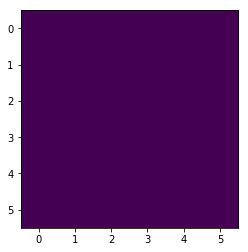

probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e-30 3.97544974e-31]
current no. cols (lambda): 1
assigned no. cols (eta_lambda): 1
probabilities for edges: [0.83470111 0.16529889]
assigned bonds (eta_edges):
[[ 0  0  0  0  0  0]
 [ 0  1  0  0  0  0]
 [ 0  0  0  0  0  1]
 [ 1  0  0  0  0  0]
 [ 0  0  0  0  0  1]
 [-1 -1 -1 -1 -1 -1]]

[[ 0  1  1  0  0 -1]
 [ 1  0  0  0  1 -1]
 [ 1  0  0  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 0  0  0  0  0 -1]
 [ 0  0  0  1  1 -1]]
probabilities

assigned max colors (eta_sites):
[[ 7 29 36 36 36 36]
 [36 36 36 36 14 36]
 [36 11  6 36 36 36]
 [15 18 29 36 36 36]
 [36 36 36 23 36 36]
 [ 3 36 36 17  4 36]]
clusters formed by bonds (eta_edge):
[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]]
retried sample (too many colors) 0 times
config:
[[2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]
 [2 2 2 2 2 2]]
probabilities for no. of colors (lambda): [8.64664717e-01 1.17019644e-01 1.58368867e-02 2.14328955e-03
 2.90062698e-04 3.92557174e-05 5.31268363e-06 7.18993544e-07
 9.73051950e-08 1.31688261e-08 1.78220681e-09 2.41195464e-10
 3.26422564e-11 4.41764902e-12 5.97863781e-13 8.09120641e-14
 1.09502571e-14 1.48195615e-15 2.00560955e-16 2.71429737e-17
 3.67340203e-18 4.97140904e-19 6.72807051e-20 9.10545327e-21
 1.23228910e-21 1.66772194e-22 2.25701621e-23 3.05453928e-24
 4.13386939e-25 5.59458385e-26 7.57144590e-27 1.02468378e-27
 1.38675869e-28 1.87677380e-29 2.53993714e

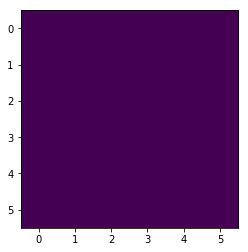

In [20]:
only_averages = False
prt = True
N, no_cols = 6, 36
gamma = 2    # strength of preference for low no. of cols
J = .9        # strength of preference for bonds
alpha = 0.01    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha, iters=300)

lambda probabilities: [6.32120559e-01 2.32544158e-01 8.55482149e-02 3.14714295e-02
 1.15776919e-02 4.25919482e-03 1.56687021e-03 5.76419338e-04
 2.12052824e-04 7.80098743e-05 2.86982290e-05 1.05574884e-05
 3.88388295e-06 1.42880069e-06 5.25626399e-07 1.93367146e-07
 7.11357975e-08 2.61693974e-08 9.62718331e-09 3.54164282e-09
 1.30289758e-09 4.79309234e-10 1.76328013e-10 6.48674509e-11
 2.38634016e-11 8.77885484e-12 3.22956021e-12 1.18808881e-12
 4.37073446e-13 1.60790335e-13 5.91514586e-14 2.17606055e-14
 8.00527940e-15 2.94497771e-15 1.08339676e-15 6.30511676e-16]
edge probabilities: [0.83470111 0.16529889]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[16  4 26 13 27 29]
 [34 36 24 19 33 34]
 [ 4 20 30 26 28  5]
 [28 13 11 16 13 28]
 [28 22 34 27  4 21]
 [13 15 31 35 36 23]]

-------------------------------------------------- iter 0 --------------------------------------------------

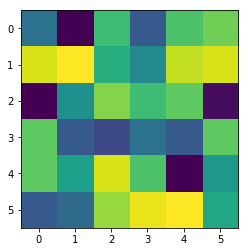


-------------------------------------------------- iter 10 --------------------------------------------------


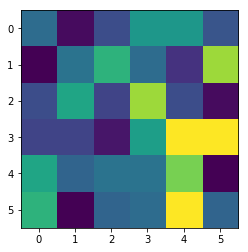


-------------------------------------------------- iter 20 --------------------------------------------------


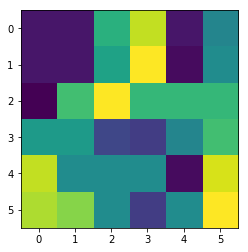


-------------------------------------------------- iter 30 --------------------------------------------------


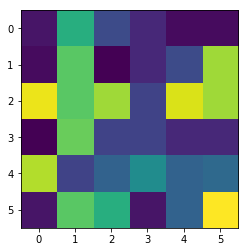


-------------------------------------------------- iter 40 --------------------------------------------------


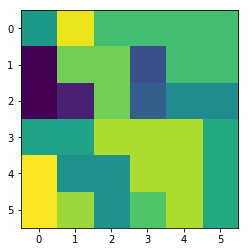


-------------------------------------------------- iter 50 --------------------------------------------------


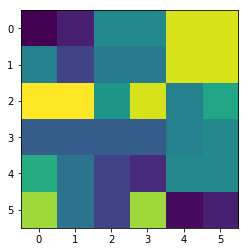


-------------------------------------------------- iter 60 --------------------------------------------------


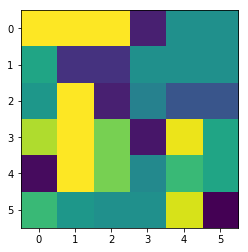


-------------------------------------------------- iter 70 --------------------------------------------------


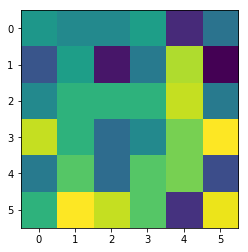


-------------------------------------------------- iter 80 --------------------------------------------------


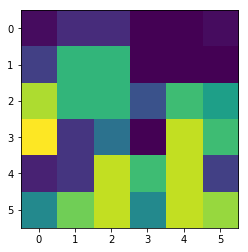


-------------------------------------------------- iter 90 --------------------------------------------------


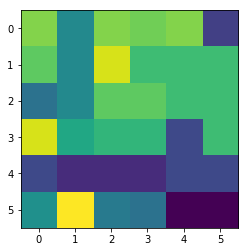


-------------------------------------------------- iter 100 --------------------------------------------------


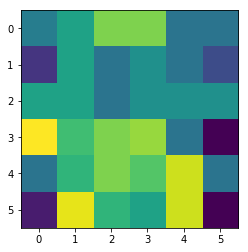


-------------------------------------------------- iter 110 --------------------------------------------------


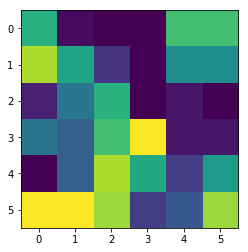


-------------------------------------------------- iter 120 --------------------------------------------------


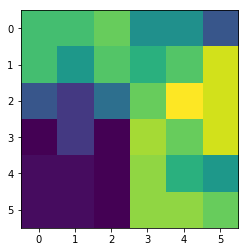


-------------------------------------------------- iter 130 --------------------------------------------------


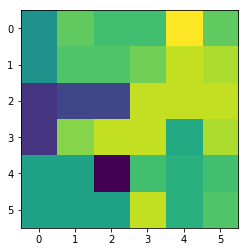


-------------------------------------------------- iter 140 --------------------------------------------------


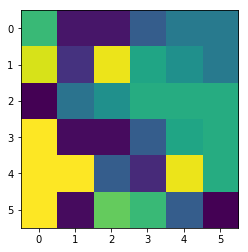


-------------------------------------------------- iter 150 --------------------------------------------------


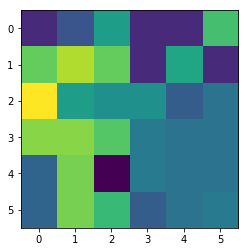


-------------------------------------------------- iter 160 --------------------------------------------------


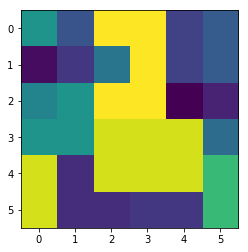


-------------------------------------------------- iter 170 --------------------------------------------------


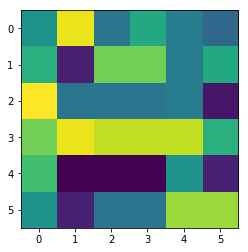


-------------------------------------------------- iter 180 --------------------------------------------------


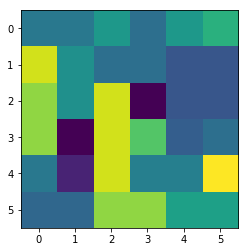


-------------------------------------------------- iter 190 --------------------------------------------------


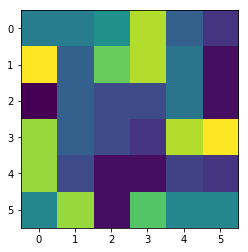


-------------------------------------------------- iter 200 --------------------------------------------------


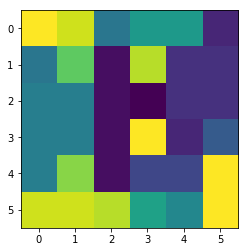


-------------------------------------------------- iter 210 --------------------------------------------------


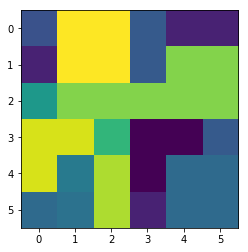


-------------------------------------------------- iter 220 --------------------------------------------------


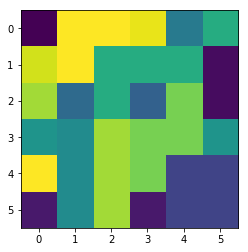


-------------------------------------------------- iter 230 --------------------------------------------------


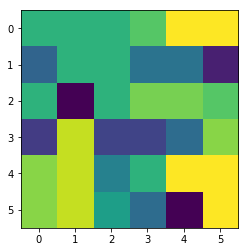


-------------------------------------------------- iter 240 --------------------------------------------------


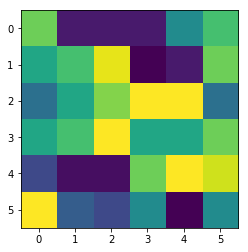


-------------------------------------------------- iter 250 --------------------------------------------------


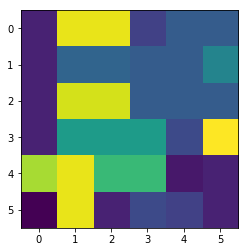


-------------------------------------------------- iter 260 --------------------------------------------------


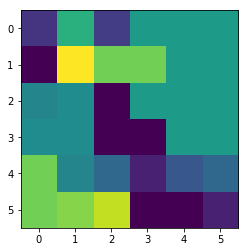


-------------------------------------------------- iter 270 --------------------------------------------------


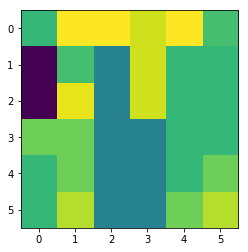


-------------------------------------------------- iter 280 --------------------------------------------------


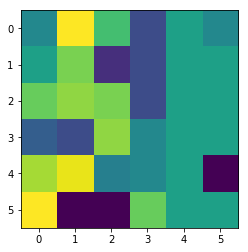


-------------------------------------------------- iter 290 --------------------------------------------------


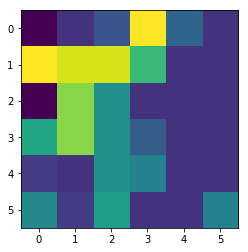


final config:
[[32 17 11  9  9 29]
 [ 9 34 15 29 29 29]
 [34 34 27 17 29 29]
 [15 34 25 14 29 29]
 [14  4  8  6 29 29]
 [26 22 15 22  6 36]]


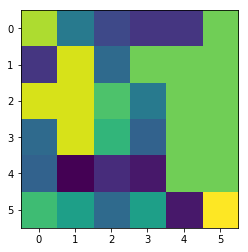

In [23]:
only_averages = False
prt = False
N, no_cols = 6, 36
gamma = 1    # strength of preference for low no. of cols
J = .9        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha, iters=300)

lambda probabilities: [6.32120559e-01 2.32544158e-01 8.55482149e-02 3.14714295e-02
 1.15776919e-02 4.25919482e-03 1.56687021e-03 5.76419338e-04
 2.12052824e-04 7.80098743e-05 2.86982290e-05 1.05574884e-05
 3.88388295e-06 1.42880069e-06 5.25626399e-07 1.93367146e-07
 7.11357975e-08 2.61693974e-08 9.62718331e-09 3.54164282e-09
 1.30289758e-09 4.79309234e-10 1.76328013e-10 6.48674509e-11
 2.38634016e-11 8.77885484e-12 3.22956021e-12 1.18808881e-12
 4.37073446e-13 1.60790335e-13 5.91514586e-14 2.17606055e-14
 8.00527940e-15 2.94497771e-15 1.08339676e-15 6.30511676e-16]
edge probabilities: [0.83470111 0.16529889]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[29 29 29 29 29 29]
 [29 29 29 29 29 29]
 [29 29 29 29 29 29]
 [29 29 29 29 29 29]
 [29 29 29 29 29 29]
 [29 29 29 29 29 29]]

-------------------------------------------------- iter 0 --------------------------------------------------

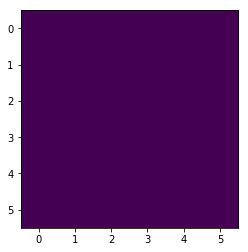


-------------------------------------------------- iter 10 --------------------------------------------------


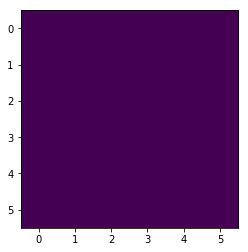


-------------------------------------------------- iter 20 --------------------------------------------------


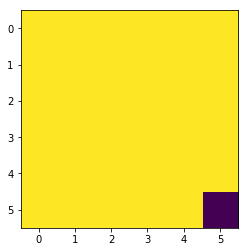


-------------------------------------------------- iter 30 --------------------------------------------------


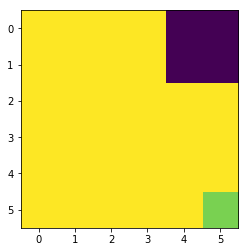


-------------------------------------------------- iter 40 --------------------------------------------------


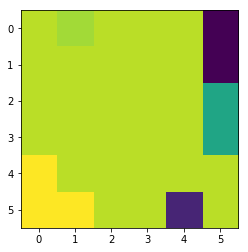


-------------------------------------------------- iter 50 --------------------------------------------------


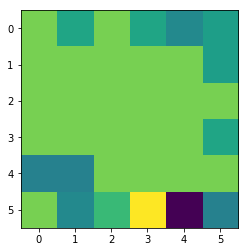


-------------------------------------------------- iter 60 --------------------------------------------------


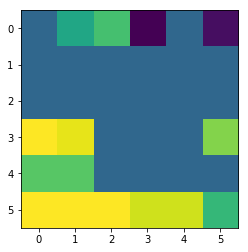


-------------------------------------------------- iter 70 --------------------------------------------------


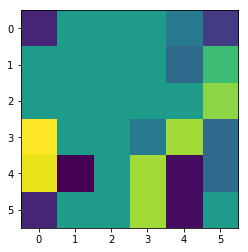


-------------------------------------------------- iter 80 --------------------------------------------------


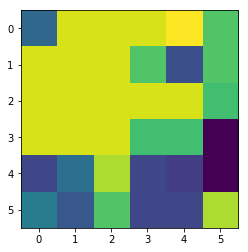


-------------------------------------------------- iter 90 --------------------------------------------------


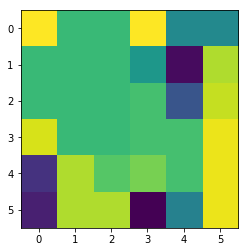


-------------------------------------------------- iter 100 --------------------------------------------------


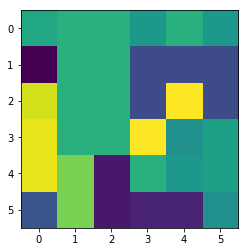


-------------------------------------------------- iter 110 --------------------------------------------------


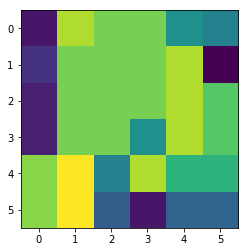


-------------------------------------------------- iter 120 --------------------------------------------------


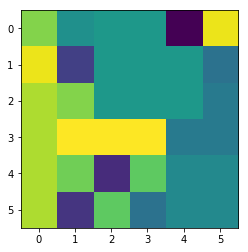


-------------------------------------------------- iter 130 --------------------------------------------------


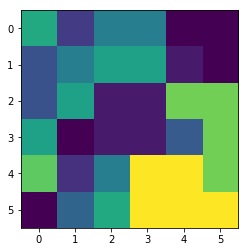


-------------------------------------------------- iter 140 --------------------------------------------------


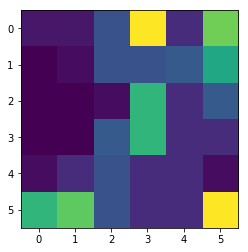


-------------------------------------------------- iter 150 --------------------------------------------------


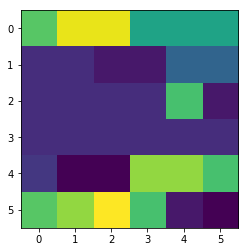


-------------------------------------------------- iter 160 --------------------------------------------------


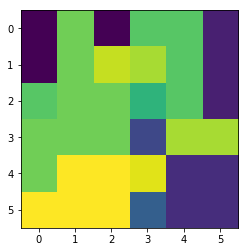


-------------------------------------------------- iter 170 --------------------------------------------------


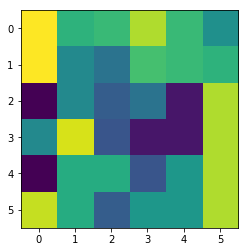


-------------------------------------------------- iter 180 --------------------------------------------------


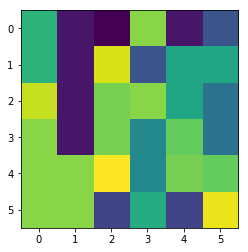


-------------------------------------------------- iter 190 --------------------------------------------------


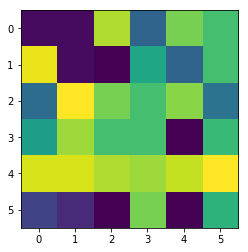


-------------------------------------------------- iter 200 --------------------------------------------------


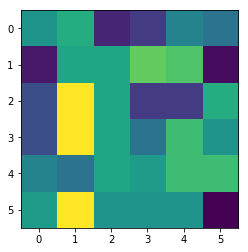


-------------------------------------------------- iter 210 --------------------------------------------------


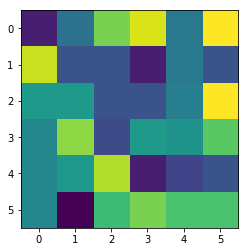


-------------------------------------------------- iter 220 --------------------------------------------------


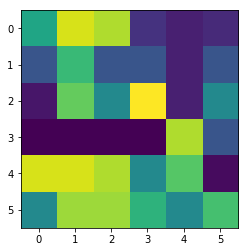


-------------------------------------------------- iter 230 --------------------------------------------------


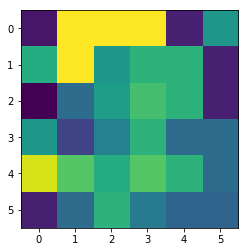


-------------------------------------------------- iter 240 --------------------------------------------------


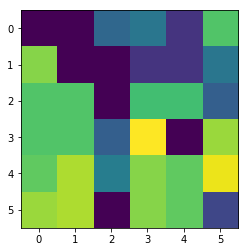


-------------------------------------------------- iter 250 --------------------------------------------------


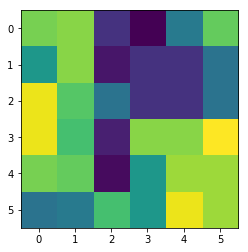


-------------------------------------------------- iter 260 --------------------------------------------------


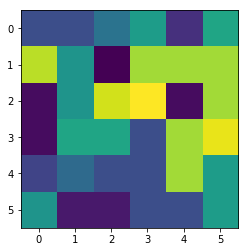


-------------------------------------------------- iter 270 --------------------------------------------------


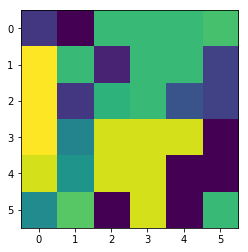


-------------------------------------------------- iter 280 --------------------------------------------------


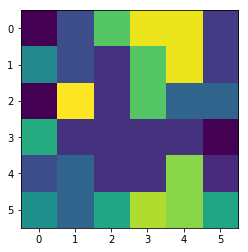


-------------------------------------------------- iter 290 --------------------------------------------------


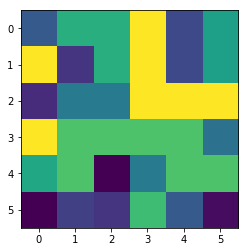


final config:
[[24 15 15 19 19  5]
 [ 4 15 15 19 19  1]
 [36 24  5 19 19 19]
 [36 17 26 12 12 19]
 [24 26 26 26 26 17]
 [24 26 26 26 24 26]]


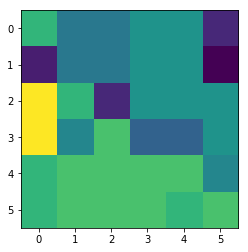

In [74]:
only_averages = False
prt = False
N, no_cols = 6, 36
gamma = 1    # strength of preference for low no. of cols
J = .9        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha, init_type="Uniform", iters=300)

lambda probabilities: [9.97521248e-01 2.47260796e-03 6.12898237e-06 1.51922284e-08
 3.76577692e-11 9.33442774e-14 2.31377331e-16 5.73527062e-19
 1.42163145e-21 3.52387206e-24 8.73480554e-27 2.16514183e-29
 5.36685001e-32 1.33030911e-34 3.29750661e-37 8.17370170e-40
 2.02605809e-42 5.02209589e-45 1.24485311e-47 3.08568236e-50
 7.64864187e-53 1.89590877e-55 4.69948799e-58 1.16488661e-60
 2.88746522e-63 7.15731069e-66 1.77411994e-68 4.39760367e-71
 1.09005697e-73 2.70198108e-76 6.69754149e-79 1.66015455e-81
 4.11511172e-84 1.02003421e-86 2.52841202e-89 6.28288051e-92]
edge probabilities: [0.63212056 0.36787944]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[22 36 23 28  6 29]
 [25 27 11 36 17 33]
 [ 7 18 12 15 21 14]
 [27 21 17  4 29  1]
 [16 35 34 12 24  8]
 [12 15 22 27 17 33]]

-------------------------------------------------- iter 0 --------------------------------------------------

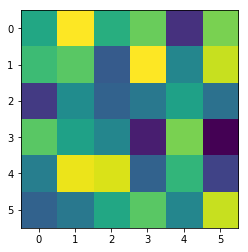


-------------------------------------------------- iter 100 --------------------------------------------------


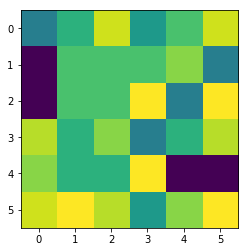


-------------------------------------------------- iter 200 --------------------------------------------------


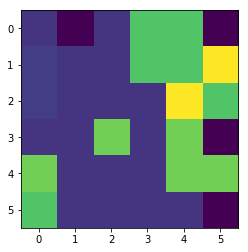


-------------------------------------------------- iter 300 --------------------------------------------------


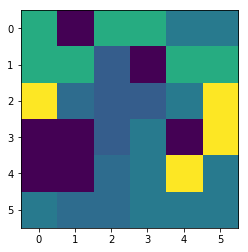


-------------------------------------------------- iter 400 --------------------------------------------------


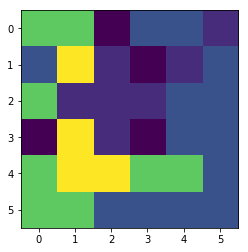


-------------------------------------------------- iter 500 --------------------------------------------------


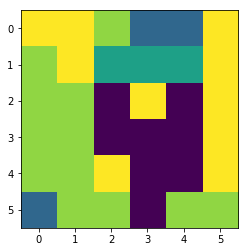


-------------------------------------------------- iter 600 --------------------------------------------------


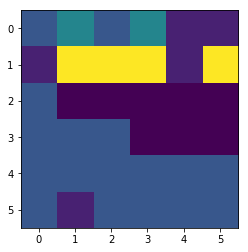


-------------------------------------------------- iter 700 --------------------------------------------------


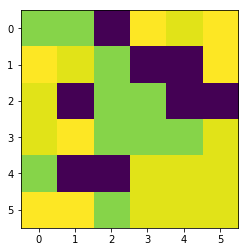


-------------------------------------------------- iter 800 --------------------------------------------------


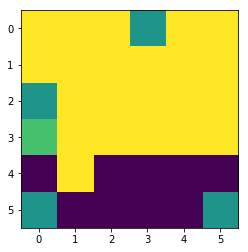


-------------------------------------------------- iter 900 --------------------------------------------------


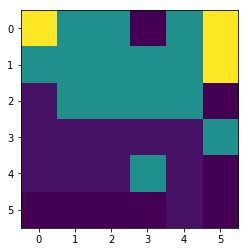


final config:
[[31 15  1  1  1 29]
 [ 1  1  1  1  1  1]
 [ 1  1  1 29  1  1]
 [ 1  1  9 29  9  1]
 [29  9  9 29  1  1]
 [ 9 29 29 29 29  1]]


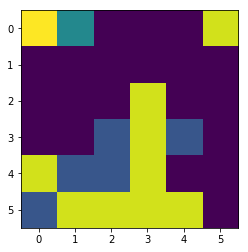

In [78]:
only_averages = False
prt = False
N, no_cols = 6, 36
gamma = 6    # strength of preference for low no. of cols
J = .5        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha, init_type="Noise", iters=1000)

lambda probabilities: [9.97521248e-01 2.47260796e-03 6.12898237e-06 1.51922284e-08
 3.76577692e-11 9.33442774e-14 2.31377331e-16 5.73527062e-19
 1.42163145e-21 3.52387206e-24 8.73480554e-27 2.16514183e-29
 5.36685001e-32 1.33030911e-34 3.29750661e-37 8.17370170e-40
 2.02605809e-42 5.02209589e-45 1.24485311e-47 3.08568236e-50
 7.64864187e-53 1.89590877e-55 4.69948799e-58 1.16488661e-60
 2.88746522e-63 7.15731069e-66 1.77411994e-68 4.39760367e-71
 1.09005697e-73 2.70198108e-76 6.69754149e-79 1.66015455e-81
 4.11511172e-84 1.02003421e-86 2.52841202e-89 6.28288051e-92]
edge probabilities: [0.63212056 0.36787944]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[7 7 7 7 7 7]
 [7 7 7 7 7 7]
 [7 7 7 7 7 7]
 [7 7 7 7 7 7]
 [7 7 7 7 7 7]
 [7 7 7 7 7 7]]

-------------------------------------------------- iter 0 --------------------------------------------------


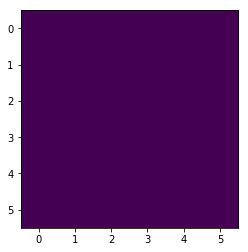


-------------------------------------------------- iter 100 --------------------------------------------------


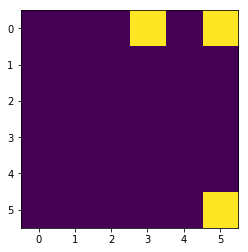


-------------------------------------------------- iter 200 --------------------------------------------------


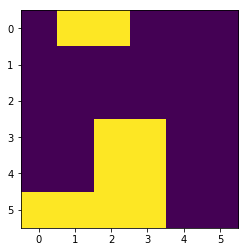


-------------------------------------------------- iter 300 --------------------------------------------------


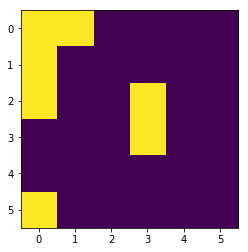


-------------------------------------------------- iter 400 --------------------------------------------------


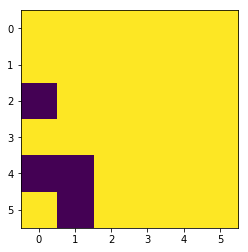


-------------------------------------------------- iter 500 --------------------------------------------------


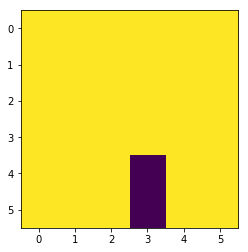


-------------------------------------------------- iter 600 --------------------------------------------------


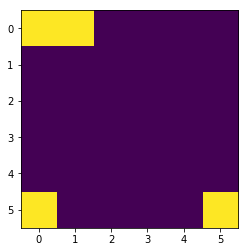


-------------------------------------------------- iter 700 --------------------------------------------------


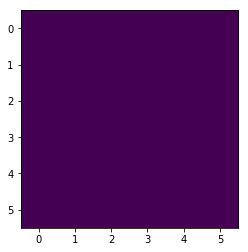


-------------------------------------------------- iter 800 --------------------------------------------------


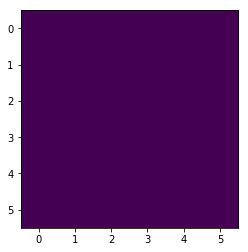


-------------------------------------------------- iter 900 --------------------------------------------------


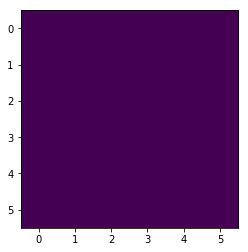


final config:
[[15 15 15 15 15 15]
 [15 15 15 15 15 15]
 [15 15 15 15 15 15]
 [15 15 15 15 15 15]
 [15 15 15 15 15 15]
 [15 15 15 15 15 15]]


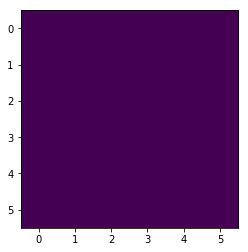

In [79]:
only_averages = False
prt = False
N, no_cols = 6, 36
gamma = 6    # strength of preference for low no. of cols
J = .5        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha, init_type="Uniform", iters=1000)

lambda probabilities: [9.97521248e-01 2.47260796e-03 6.12898237e-06 1.51922284e-08
 3.76577692e-11 9.33442774e-14 2.31377331e-16 5.73527062e-19
 1.42163145e-21 3.52387206e-24 8.73480554e-27 2.16514183e-29
 5.36685001e-32 1.33030911e-34 3.29750661e-37 8.17370170e-40
 2.02605809e-42 5.02209589e-45 1.24485311e-47 3.08568236e-50
 7.64864187e-53 1.89590877e-55 4.69948799e-58 1.16488661e-60
 2.88746522e-63 7.15731069e-66 1.77411994e-68 4.39760367e-71
 1.09005697e-73 2.70198108e-76 6.69754149e-79 1.66015455e-81
 4.11511172e-84 1.02003421e-86 2.52841202e-89 6.28288051e-92]
edge probabilities: [0.63212056 0.36787944]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[30 30 30 30 30 30]
 [30 30 30 30 30 30]
 [30 30 30 30 30 30]
 [30 30 30 30 30 30]
 [30 30 30 30 30 30]
 [30 30 30 30 30 30]]

-------------------------------------------------- iter 0 --------------------------------------------------

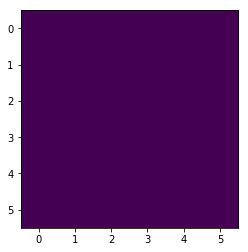

1

-------------------------------------------------- iter 100 --------------------------------------------------


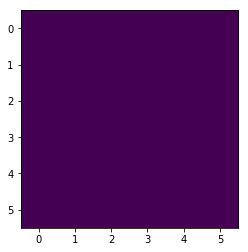

1

-------------------------------------------------- iter 200 --------------------------------------------------


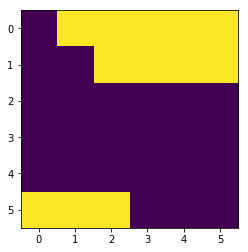

2

-------------------------------------------------- iter 300 --------------------------------------------------


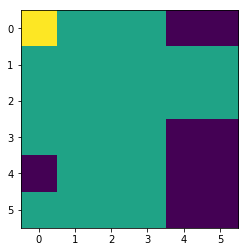

3

-------------------------------------------------- iter 400 --------------------------------------------------


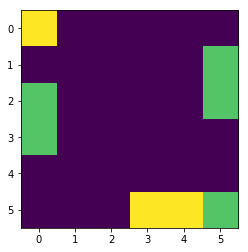

3

-------------------------------------------------- iter 500 --------------------------------------------------


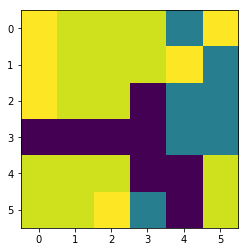

4

-------------------------------------------------- iter 600 --------------------------------------------------


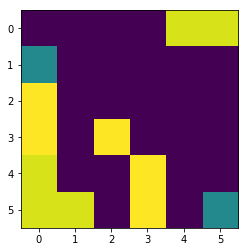

4

-------------------------------------------------- iter 700 --------------------------------------------------


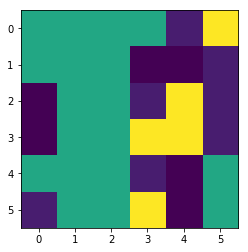

4

-------------------------------------------------- iter 800 --------------------------------------------------


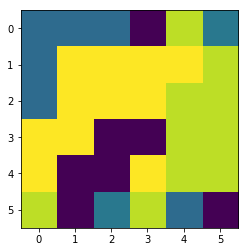

5

-------------------------------------------------- iter 900 --------------------------------------------------


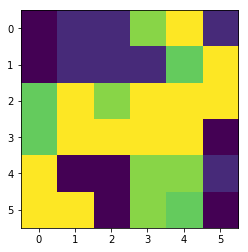

5

-------------------------------------------------- iter 1000 --------------------------------------------------


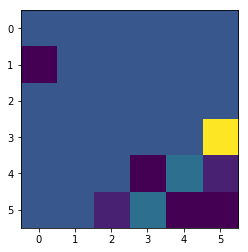

5

-------------------------------------------------- iter 1100 --------------------------------------------------


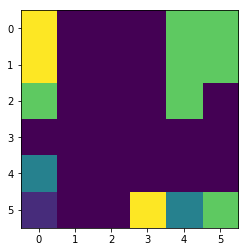

5

-------------------------------------------------- iter 1200 --------------------------------------------------


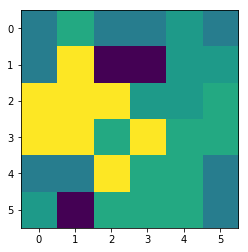

5

-------------------------------------------------- iter 1300 --------------------------------------------------


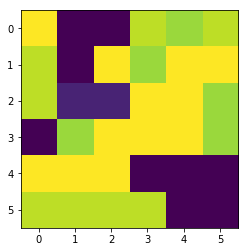

5

-------------------------------------------------- iter 1400 --------------------------------------------------


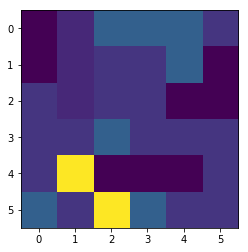

5

-------------------------------------------------- iter 1500 --------------------------------------------------


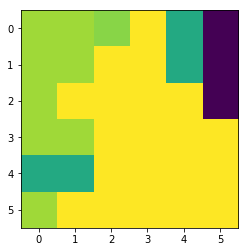

5

-------------------------------------------------- iter 1600 --------------------------------------------------


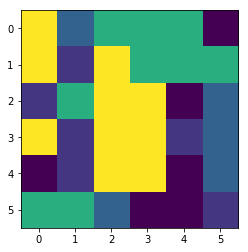

5

-------------------------------------------------- iter 1700 --------------------------------------------------


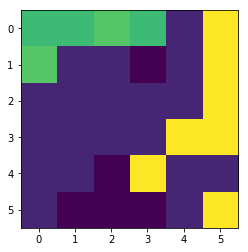

5

-------------------------------------------------- iter 1800 --------------------------------------------------


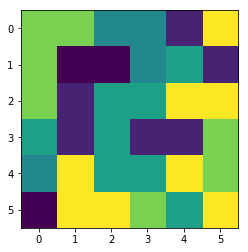

6

-------------------------------------------------- iter 1900 --------------------------------------------------


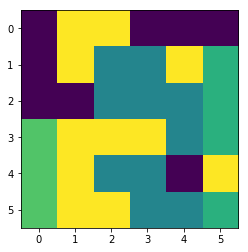

5

-------------------------------------------------- iter 2000 --------------------------------------------------


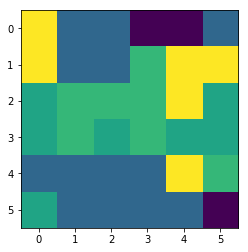

5

-------------------------------------------------- iter 2100 --------------------------------------------------


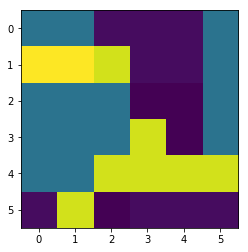

5

-------------------------------------------------- iter 2200 --------------------------------------------------


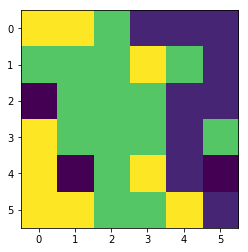

4

-------------------------------------------------- iter 2300 --------------------------------------------------


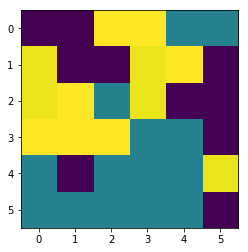

4

-------------------------------------------------- iter 2400 --------------------------------------------------


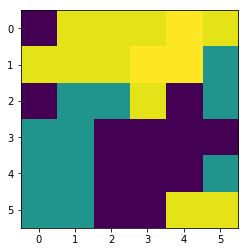

4

-------------------------------------------------- iter 2500 --------------------------------------------------


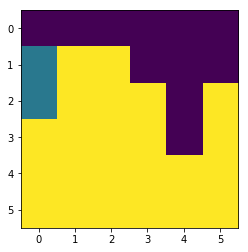

3

-------------------------------------------------- iter 2600 --------------------------------------------------


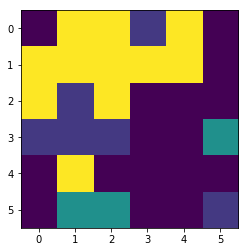

4

-------------------------------------------------- iter 2700 --------------------------------------------------


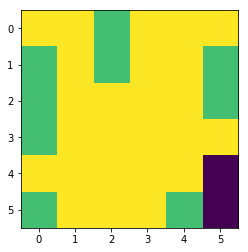

3

-------------------------------------------------- iter 2800 --------------------------------------------------


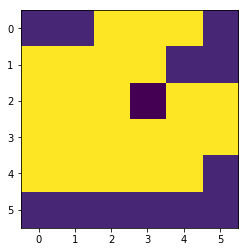

3

-------------------------------------------------- iter 2900 --------------------------------------------------


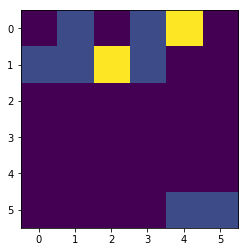

3

-------------------------------------------------- iter 3000 --------------------------------------------------


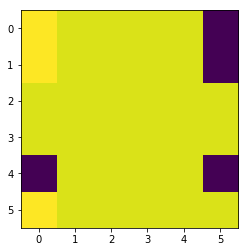

3

-------------------------------------------------- iter 3100 --------------------------------------------------


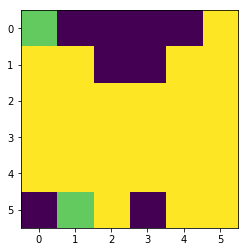

3

-------------------------------------------------- iter 3200 --------------------------------------------------


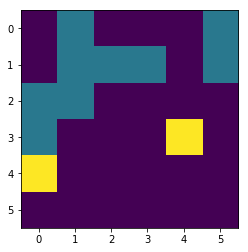

3

-------------------------------------------------- iter 3300 --------------------------------------------------


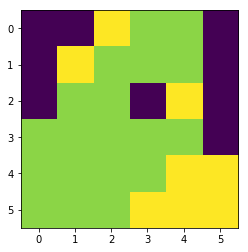

3

-------------------------------------------------- iter 3400 --------------------------------------------------


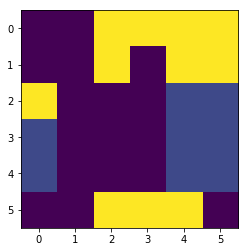

3

-------------------------------------------------- iter 3500 --------------------------------------------------


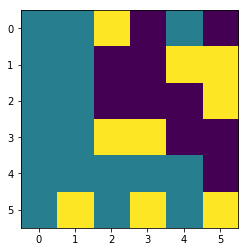

3

-------------------------------------------------- iter 3600 --------------------------------------------------


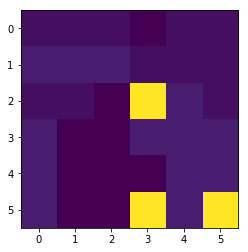

4

-------------------------------------------------- iter 3700 --------------------------------------------------


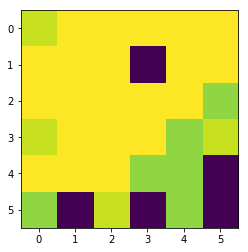

4

-------------------------------------------------- iter 3800 --------------------------------------------------


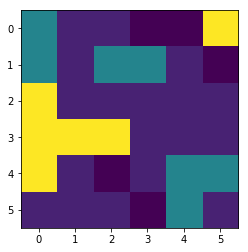

4

-------------------------------------------------- iter 3900 --------------------------------------------------


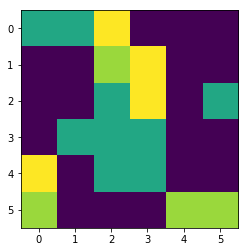

4

-------------------------------------------------- iter 4000 --------------------------------------------------


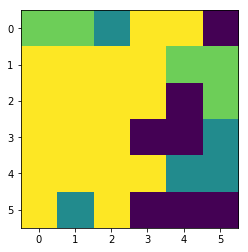

4

-------------------------------------------------- iter 4100 --------------------------------------------------


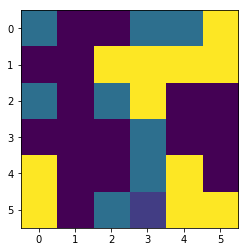

4

-------------------------------------------------- iter 4200 --------------------------------------------------


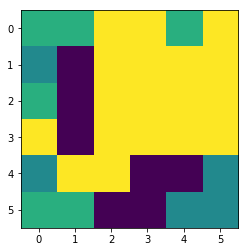

4

-------------------------------------------------- iter 4300 --------------------------------------------------


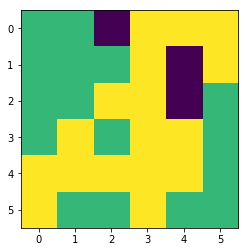

3

-------------------------------------------------- iter 4400 --------------------------------------------------


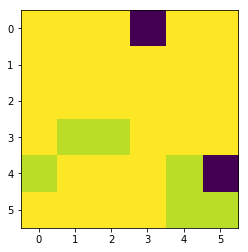

3

-------------------------------------------------- iter 4500 --------------------------------------------------


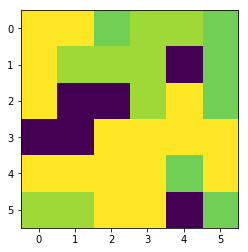

4

-------------------------------------------------- iter 4600 --------------------------------------------------


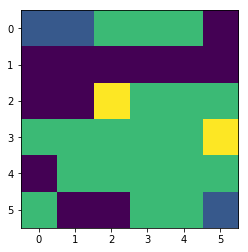

4

-------------------------------------------------- iter 4700 --------------------------------------------------


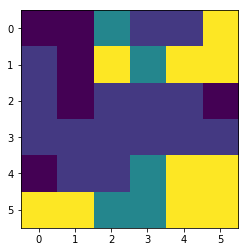

4

-------------------------------------------------- iter 4800 --------------------------------------------------


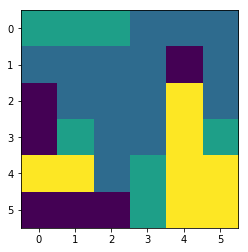

4

-------------------------------------------------- iter 4900 --------------------------------------------------


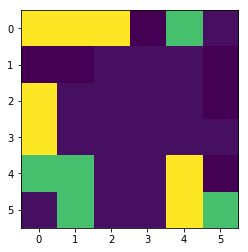

4

final config:
[[26  5 26 26 26  5]
 [30 30 30 26 26 26]
 [10 30 30 26  5 30]
 [30 30 30 30 10 30]
 [30 30 30 30 10 10]
 [30 30  5  5 10 10]]
4


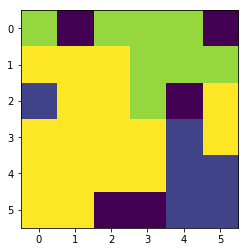

In [27]:
only_averages = False
prt = False
N, no_cols = 6, 36
gamma = 6    # strength of preference for low no. of cols
J = .5        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha, init_type="Uniform", iters=5000)

lambda probabilities: [9.97521248e-01 2.47260796e-03 6.12898237e-06 1.51922284e-08
 3.76577692e-11 9.33442774e-14 2.31377331e-16 5.73527062e-19
 1.42163145e-21 3.52387206e-24 8.73480554e-27 2.16514183e-29
 5.36685001e-32 1.33030911e-34 3.29750661e-37 8.17370170e-40
 2.02605809e-42 5.02209589e-45 1.24485311e-47 3.08568236e-50
 7.64864187e-53 1.89590877e-55 4.69948799e-58 1.16488661e-60
 2.88746522e-63 7.15731069e-66 1.77411994e-68 4.39760367e-71
 1.09005697e-73 2.70198108e-76 6.69754149e-79 1.66015455e-81
 4.11511172e-84 1.02003421e-86 2.52841202e-89 6.28288051e-92]
edge probabilities: [0.63212056 0.36787944]
site probabilities: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

initial config:
[[30 30 21 16 30 18]
 [ 4 21 14 32 27  8]
 [14 20  9 10 30 22]
 [30  6  9 28  7 23]
 [ 6 35  2 22 20  6]
 [16  1 19  4  3  7]]

-------------------------------------------------- iter 0 --------------------------------------------------

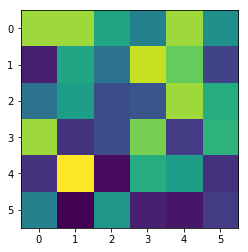

22

-------------------------------------------------- iter 100 --------------------------------------------------


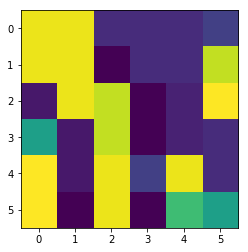

10

-------------------------------------------------- iter 200 --------------------------------------------------


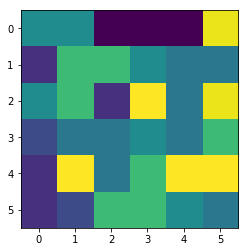

8

-------------------------------------------------- iter 300 --------------------------------------------------


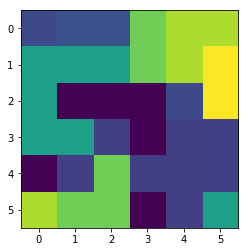

8

-------------------------------------------------- iter 400 --------------------------------------------------


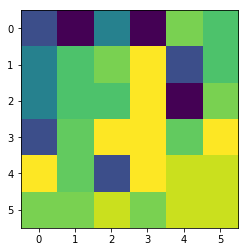

8

-------------------------------------------------- iter 500 --------------------------------------------------


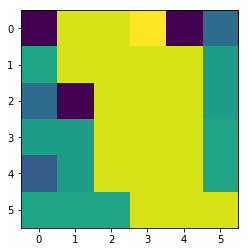

7

-------------------------------------------------- iter 600 --------------------------------------------------


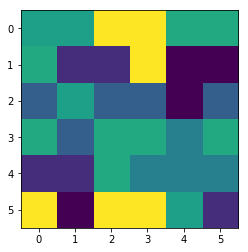

7

-------------------------------------------------- iter 700 --------------------------------------------------


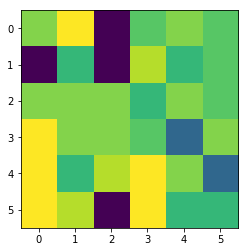

7

-------------------------------------------------- iter 800 --------------------------------------------------


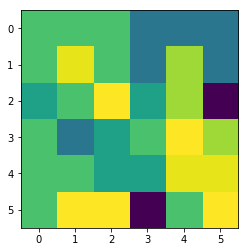

7

-------------------------------------------------- iter 900 --------------------------------------------------


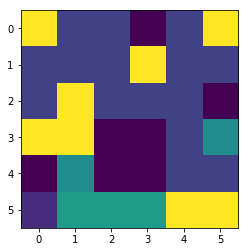

6

-------------------------------------------------- iter 1000 --------------------------------------------------


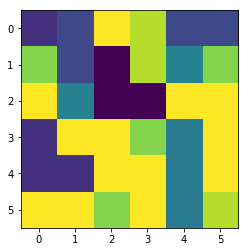

8

-------------------------------------------------- iter 1100 --------------------------------------------------


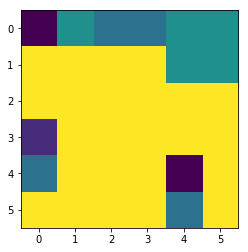

5

-------------------------------------------------- iter 1200 --------------------------------------------------


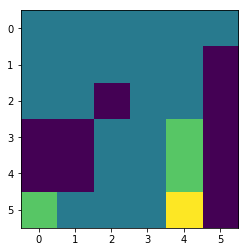

4

-------------------------------------------------- iter 1300 --------------------------------------------------


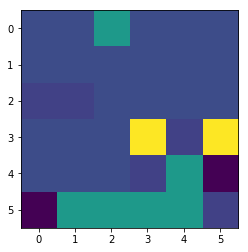

5

-------------------------------------------------- iter 1400 --------------------------------------------------


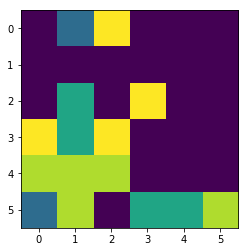

5

-------------------------------------------------- iter 1500 --------------------------------------------------


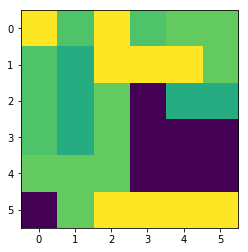

5

-------------------------------------------------- iter 1600 --------------------------------------------------


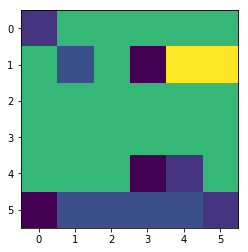

5

-------------------------------------------------- iter 1700 --------------------------------------------------


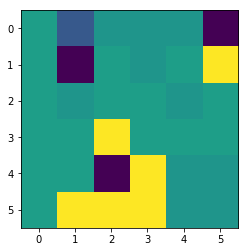

5

-------------------------------------------------- iter 1800 --------------------------------------------------


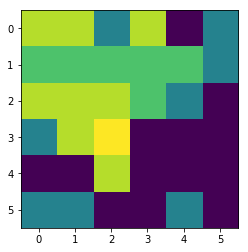

5

-------------------------------------------------- iter 1900 --------------------------------------------------


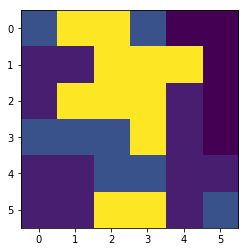

4

-------------------------------------------------- iter 2000 --------------------------------------------------


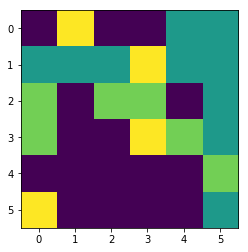

4

-------------------------------------------------- iter 2100 --------------------------------------------------


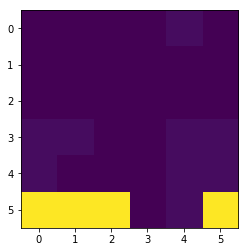

3

-------------------------------------------------- iter 2200 --------------------------------------------------


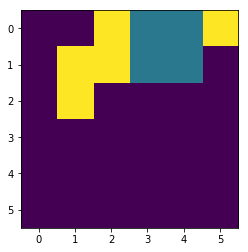

3

-------------------------------------------------- iter 2300 --------------------------------------------------


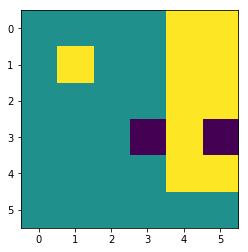

3

-------------------------------------------------- iter 2400 --------------------------------------------------


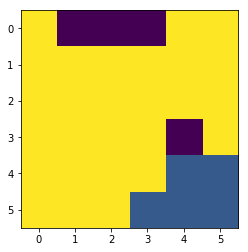

3

-------------------------------------------------- iter 2500 --------------------------------------------------


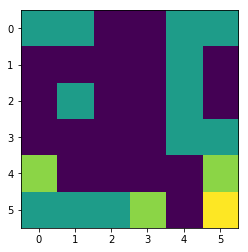

4

-------------------------------------------------- iter 2600 --------------------------------------------------


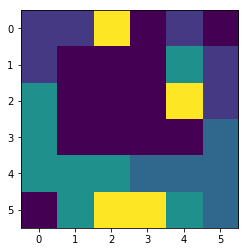

5

-------------------------------------------------- iter 2700 --------------------------------------------------


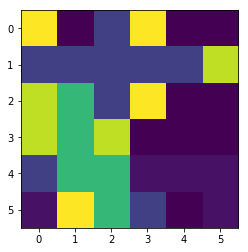

6

-------------------------------------------------- iter 2800 --------------------------------------------------


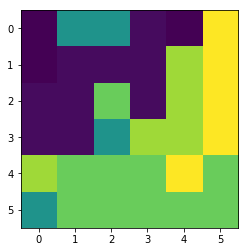

6

-------------------------------------------------- iter 2900 --------------------------------------------------


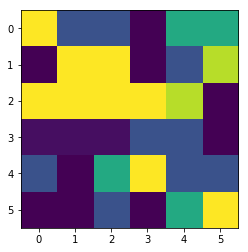

6

-------------------------------------------------- iter 3000 --------------------------------------------------


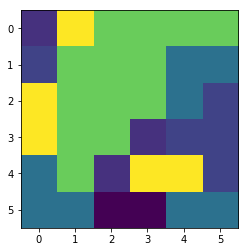

6

-------------------------------------------------- iter 3100 --------------------------------------------------


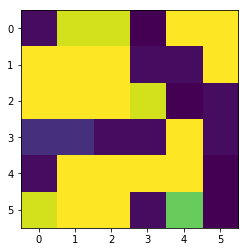

6

-------------------------------------------------- iter 3200 --------------------------------------------------


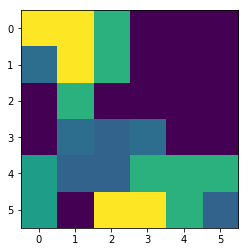

6

-------------------------------------------------- iter 3300 --------------------------------------------------


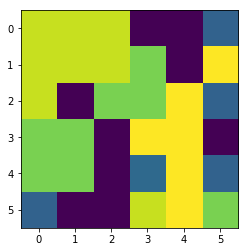

6

-------------------------------------------------- iter 3400 --------------------------------------------------


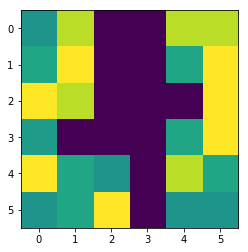

6

-------------------------------------------------- iter 3500 --------------------------------------------------


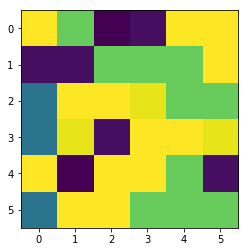

6

-------------------------------------------------- iter 3600 --------------------------------------------------


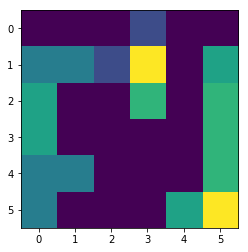

6

-------------------------------------------------- iter 3700 --------------------------------------------------


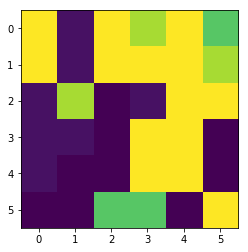

5

-------------------------------------------------- iter 3800 --------------------------------------------------


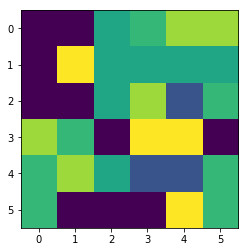

6

-------------------------------------------------- iter 3900 --------------------------------------------------


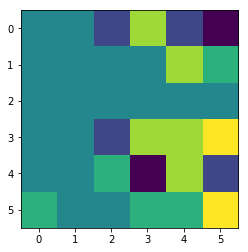

6

-------------------------------------------------- iter 4000 --------------------------------------------------


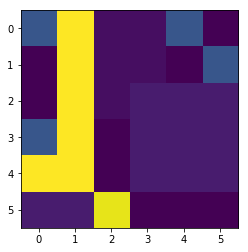

6

-------------------------------------------------- iter 4100 --------------------------------------------------


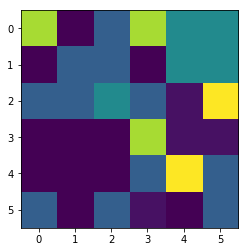

6

-------------------------------------------------- iter 4200 --------------------------------------------------


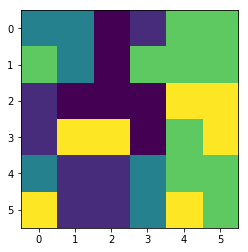

5

-------------------------------------------------- iter 4300 --------------------------------------------------


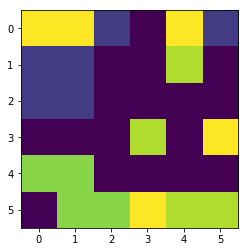

5

-------------------------------------------------- iter 4400 --------------------------------------------------


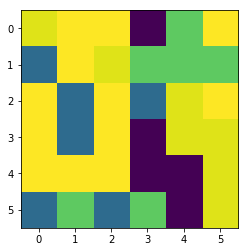

5

-------------------------------------------------- iter 4500 --------------------------------------------------


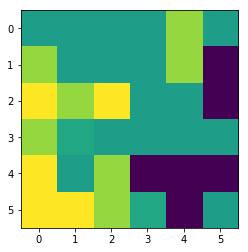

5

-------------------------------------------------- iter 4600 --------------------------------------------------


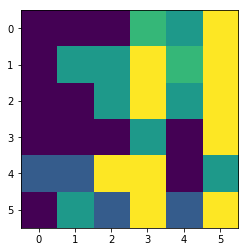

5

-------------------------------------------------- iter 4700 --------------------------------------------------


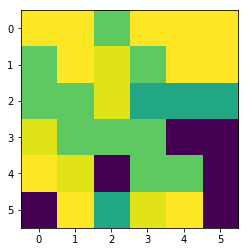

5

-------------------------------------------------- iter 4800 --------------------------------------------------


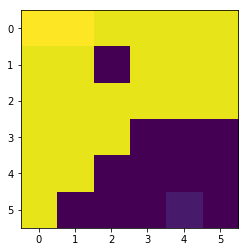

4

-------------------------------------------------- iter 4900 --------------------------------------------------


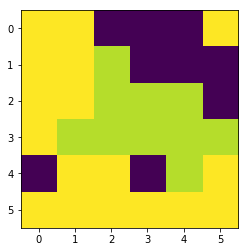

3

-------------------------------------------------- iter 5000 --------------------------------------------------


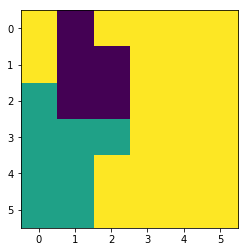

3

-------------------------------------------------- iter 5100 --------------------------------------------------


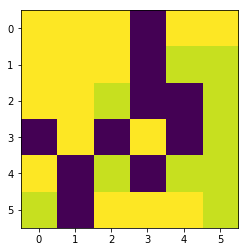

3

-------------------------------------------------- iter 5200 --------------------------------------------------


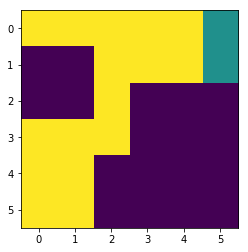

3

-------------------------------------------------- iter 5300 --------------------------------------------------


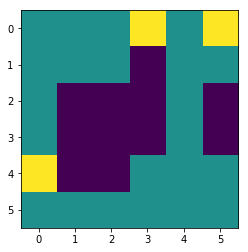

3

-------------------------------------------------- iter 5400 --------------------------------------------------


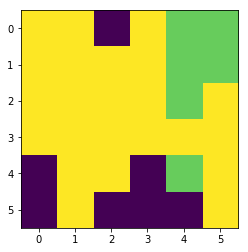

3

-------------------------------------------------- iter 5500 --------------------------------------------------


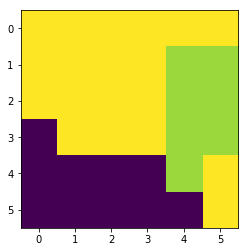

3

-------------------------------------------------- iter 5600 --------------------------------------------------


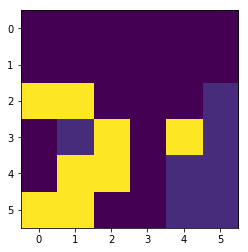

3

-------------------------------------------------- iter 5700 --------------------------------------------------


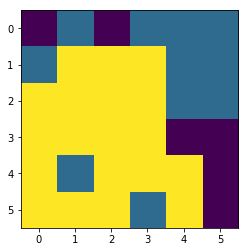

3

-------------------------------------------------- iter 5800 --------------------------------------------------


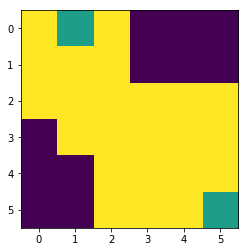

3

-------------------------------------------------- iter 5900 --------------------------------------------------


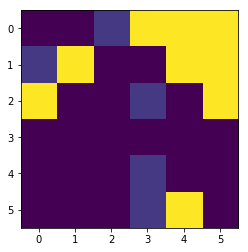

3

final config:
[[20 15 15 15 11  9]
 [11 11 15 15 11  9]
 [20 11 11  9 20 11]
 [20 20 15  9 20  9]
 [ 9 11 11 15  9  9]
 [11 11 11 11 11 20]]
4


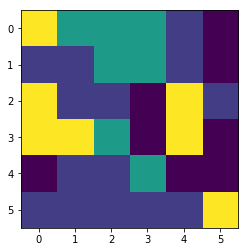

In [25]:
only_averages = False
prt = False
N, no_cols = 6, 36
gamma = 6    # strength of preference for low no. of cols
J = .5        # strength of preference for bonds
alpha = 0    # strength of preference for colors (field)

single_experiment (N, no_cols, gamma=gamma, J=J, alpha=alpha, init_type="Noise", iters=6000)

In [470]:
import pandas as pd
def plot_phase (N, no_cols, param_name, param_name2, save_opts=""):
    df = pd.read_csv("Simulation_all_interaction_data/avg_std_("
                        + str(N)+ "," + str(no_cols) + ")"
                        + "_vary_" + param_name
                        + "_vary_" + param_name2 + "_steps_" + str((eq_steps, mc_steps)) + "_"
                        + save_opts + ".csv")
    
    df["Avg. no. of colors"] = [int(x) for x in df["Avg. no. of colors"]]
    df = df[df['J']<=2]
    df = df[df['Gamma']<=12]
    df = df[df['Avg. no. of colors']>1]
    print(df.head())
    
    df.plot.scatter(x=param_name2,
                    y=param_name,
                    c="Avg. no. of colors",
                    cmap="gnuplot2",
                    title = str(N*N) + " total sites / " + str(no_cols) + " colors",
                    figsize = (6,4))
    
    plt.savefig("Simulation_all_interaction/phase_("
                + str(N)+ "," + str(no_cols) + ")"
                + "_vary_" + param_name
                + "_vary_" + param_name2 + "_steps_" + str((eq_steps, mc_steps)) + "_"
                + save_opts + ".png", format="png")
    plt.show()

   Unnamed: 0    J  Gamma  Avg. no. of colors      Std.
0           0  0.0    0.0                  10  1.232934
1           1  0.1    0.0                  10  1.307750
2           2  0.2    0.0                   9  1.269702
3           3  0.3    0.0                   9  1.354856
4           4  0.4    0.0                   9  1.284288


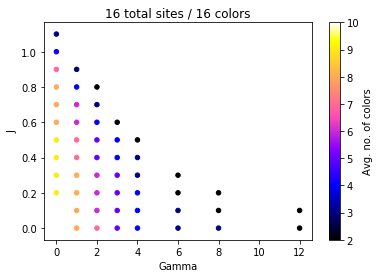

In [471]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
N = 4

plot_phase (N, N*N, "J", "Gamma")

   Unnamed: 0    J  Gamma  Avg. no. of colors      Std.
0           0  0.0    0.0                  15  1.554289
1           1  0.1    0.0                  15  1.564787
2           2  0.2    0.0                  15  1.524588
3           3  0.3    0.0                  15  1.639898
4           4  0.4    0.0                  15  1.591770


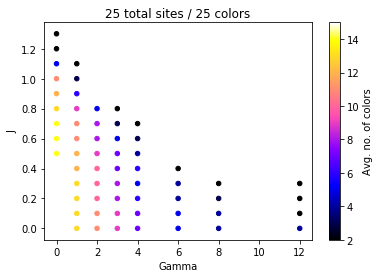

In [472]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
N = 5

plot_phase (N, N*N, "J", "Gamma")

   Unnamed: 0    J  Gamma  Avg. no. of colors      Std.
0           0  0.0    0.0                  22  1.938359
1           1  0.1    0.0                  22  1.890292
2           2  0.2    0.0                  22  1.920340
3           3  0.3    0.0                  22  1.847885
4           4  0.4    0.0                  22  1.935854


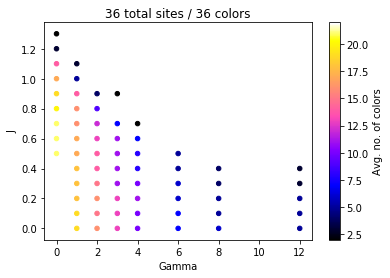

In [473]:
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
N = 6

plot_phase (N, N*N, "J", "Gamma")